In [1]:
import time
from multiprocessing import Pool

from IPython.display import display

from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from itertools import cycle
lstyle = cycle(('-', '--', ':', '-.',\
    (0, (1, 10)), (0, (5, 10)),\
    (0, (5, 5)), (0, (3, 10, 1, 10)),\
    (0, (3, 5, 1, 5)), \
    (0, (3, 5, 1, 5, 1, 5))))
color = cycle(('#1f77b4', '#ff7f0e', '#2ca02c',\
    '#d62728', '#9467bd', '#8c564b', '#e377c2',\
    '#7f7f7f', '#bcbd22', '#17becf'))


from scipy.sparse import *
from scipy.sparse.linalg import spsolve

Система уравнений
\begin{equation}
  \begin{split}
    \varphi_t^{(1)}&+6\sigma_0\varphi^{(1)}\varphi_\eta^{(1)}+\varphi_{\eta\eta\eta}^{(1)}\mp 
6\sigma_1{\varphi^{(1)}}^2\varphi_\eta^{(1)}+
      \varphi^{(1)}-\varphi^{(2)}=0,\\
    \varphi_t^{(2)}&+6\sigma_0\varphi^{(2)}\varphi_\eta^{(2)}+\varphi_{\eta\eta\eta}^{(2)}\mp 
6\sigma_1{\varphi^{(2)}}^2\varphi_\eta^{(2)}+
      \varphi^{(2)}-\varphi^{(1)} - \sigma \varphi^{(2)} =0.
  \end{split} \tag{1.57}
\end{equation} 

Разностная схема
\begin{equation}
\begin{gathered}
\frac{{u^{(1)}}_{j}^{n+1} -{u^{(1)}}_{j}^{n} }{\tau } +3\sigma_0\frac{({{u^{(1)}}^{2}} _{j+1}^{n+1} -
{{u^{(1)}}^{2}}_{j-1}^{n+1} )+({{u^{(1)}}^{2}} _{j+1}^{n} -{{u^{(1)}}^{2}} _{j-1}^{n} )}{4h} \mp {} \hfill \\
\mp 2\sigma_1\frac{({{u^{(1)}}^{3}} _{j+1}^{n+1} -
{{u^{(1)}}^{3}}_{j-1}^{n+1} )+({{u^{(1)}}^{3}} _{j+1}^{n} -{{u^{(1)}}^{3}} _{j-1}^{n} )}{4h} + {} \\
{} +(({u^{(1)}}_{j+2}^{n+1} -2{u^{(1)}}_{j+1}^{n+1} +2{u^{(1)}}_{j-1}^{n+1} -{u^{(1)}}_{j-2}^{n+1})+ {} \\
{} + ({u^{(1)}}_{j+2}^{n} -2{u^{(1)}}_{j+1}^{n} +2{u^{(1)}}_{j-1}^{n} -{u^{(1)}}_{j-2}^{n} ))/{4h^{3} } + {}\\
\hfill {}
 +\frac{{u^{(1)}}_{j}^{n+1} +{u^{(1)}}_{j}^{n}}{2}-\frac{{u^{(2)}}_{j}^{n+1} +{u^{(2)}}_{j}^{n}}{2}=0.\\
\frac{{u^{(2)}}_{j}^{n+1} -{u^{(2)}}_{j}^{n} }{\tau} +3\sigma_0\frac{({{u^{(2)}}^{2}} _{j+1}^{n+1} -
{{u^{(2)}}^{2}}_{j-1}^{n+1} )+({{u^{(2)}}^{2}} _{j+1}^{n} -{{u^{(2)}}^{2}} _{j-1}^{n} )}{4h} \mp {} \hfill \\
\mp 2\sigma_1\frac{({{u^{(2)}}^{3}} _{j+1}^{n+1} -
{{u^{(2)}}^{3}}_{j-1}^{n+1} )+({{u^{(2)}}^{3}} _{j+1}^{n} -{{u^{(2)}}^{3}} _{j-1}^{n} )}{4h} + {} \\
{} +(({u^{(2)}}_{j+2}^{n+1} -2{u^{(2)}}_{j+1}^{n+1} +2{u^{(2)}}_{j-1}^{n+1} -{u^{(2)}}_{j-2}^{n+1})+{} \\
{} + ({u^{(2)}}_{j+2}^{n} -2{u^{(2)}}_{j+1}^{n} +2{u^{(2)}}_{j-1}^{n} -{u^{(2)}}_{j-2}^{n} ))/{4h^{3} } - {}\\ 
\hfill {}
+\frac{{u^{(2)}}_{j}^{n+1} +{u^{(2)}}_{j}^{n}}{2} -\frac{{u^{(1)}}_{j}^{n+1} +{u^{(1)}}_{j}^{n}}{2} - \sigma\frac{{u^{(2)}}_{j}^{n+1} +{u^{(2)}}_{j}^{n}}{2}=0. 
\end{gathered} \tag{2.4}
\end{equation}

In [2]:
def solve(u10, u20, dt, dx, t1, n):
    """
    u0, U0 - начальное приближение
    dt - шаг по t
    dx - шаг по x
    t1 - конечное время
    n - число шагов по времени
    """
    N = len(u10)
    assert N == len(u20)
    assert 25 <= N
    
    
    # вспомогательные массивы для задания разреженной матрицы
    row = empty((2, N, 6), dtype=int32)
    col = zeros((2, N, 6), dtype=int32)
    data = zeros((2, N, 6), dtype=float64)
    
    # столбец свободных членов
    b = zeros((2, N), dtype=float64)
    
    # за нормировку строк матрицы взято dt/dx = O(1)
    for i in range(N):
        row[0, i] = i
        row[1, i] = N+i
    for i in range(2, N-2):
        col[0, i] = i-2, i-1, i, i+1, i+2, N+i
        col[1, i] = N+i-2, N+i-1, N+i, N+i+1, N+i+2, i
            
    # граничные условия в точке x[0]
    col[0, 0, :3] = 0, 1, 2
    col[1, 0, :3] = N, N+1, N+2
    data[:, 0, :3] = -3., 4., -1.
    # граничные условия в точке x[1]
    col[0, 1, :3] = 0, 1, 2
    col[1, 1, :3] = N, N+1, N+2
    data[:, 1, :3] = -1., 0., 1.
    # граничные условия в точке x[-2]
    col[0, -2, :3] = N-1, N-2, N-3
    col[1, -2, :3] = 2*N-1, 2*N-2, 2*N-3
    data[:, -2, :3] = -1., 0., 1.
    # граничные условия в точке x[-1]
    col[0, -1, :3] = N-1, N-2, N-3
    col[1, -1, :3] = 2*N-1, 2*N-2, 2*N-3
    data[:, -1, :3] = -3., 4., -1.
    
    # задание неизменных элементов матрицы
    # (ответственны за линейные члены)
    data[:, 2:-2, 0] = -dt/(4.*dx**3)
    data[:, 2:-2, 4] = dt/(4.*dx**3)
    data[:, 2:-2, 5] = -dt/2.

    data[0, 2:-2, 2] = 1. + dt/2.
    data[1, 2:-2, 2] = 1. + dt/2.*(1.-sigma)
            
    # начальное условие, накопление промежуточных решений
    # с шагом по времени k*dt и в количестве n
    u, sol1, sol2, k = concatenate((u10, u20)),\
                                        [(0.0, u10, zeros_like(u10), zeros_like(u10),\
                                            zeros_like(u10), zeros_like(u10))],\
                                        [(0.0, u20, zeros_like(u20), zeros_like(u20),\
                                            zeros_like(u20), zeros_like(u20))],\
                                        int(t1/dt)//n
    print(f"dt={dt}, t1={t1}, шагов={int(t1/dt)}, вывод через {k} шагов")
    assert k > 4
    pf1, pf2 = 0., 0.
    kf1, kf2 = 0., 0.
    for i in range(1, int(t1/dt)):
        # начало простой итерации для построения v решения для следующего временного слоя 
        v, f, j = copy(u), True, 0
        while f:
            # задание переменных элементов матрицы
            # (ответственны за нелинейные члены)
            data[0, 2:-2, 1] = dt/dx*(-f2*v[1:N-3]/2. \
                            - f3*v[1:N-3]**2*(3./4.) + 2./(4.*dx**2))
            data[0, 2:-2, 3] = dt/dx*(f2*v[3:N-1]/2. \
                            + f3*v[3:N-1]**2*(3./4.) - 2./(4.*dx**2))
            data[1, 2:-2, 1] = dt/dx*(-f2*v[N+1:-3]/2. \
                            - f3*v[N+1:-3]**2*(3./4.) + 2./(4.*dx**2))
            data[1, 2:-2, 3] = dt/dx*(f2*v[N+3:-1]/2. \
                            + f3*v[N+3:-1]**2*(3./4.) - 2./(4.*dx**2))
            # вычисление правой части
            b[0, 2:-2] = u[2:N-2] + dt/dx*(\
                        + f2*(v[3:N-1]**2 - v[1:N-3]**2)/4.\
                        - f2*(u[3:N-1]**2 - u[1:N-3]**2)/4.\
                        + f3*(v[3:N-1]**3 - v[1:N-3]**3)/2.\
                        - f3*(u[3:N-1]**3 - u[1:N-3]**3)/4.\
                        - (u[4:N] - 2.*u[3:N-1] + 2.*u[1:N-3] - u[:N-4])/(4.*dx**2))\
                        - (u[2:N-2] - u[N+2:-2])*(dt/2.)
            b[1, 2:-2] = u[N+2:-2] + dt/dx*(\
                        + f2*(v[N+3:-1]**2 - v[N+1:-3]**2)/4.\
                        - f2*(u[N+3:-1]**2 - u[N+1:-3]**2)/4.\
                        + f3*(v[N+3:-1]**3 - v[N+1:-3]**3)/2.\
                        - f3*(u[N+3:-1]**3 - u[N+1:-3]**3)/4.\
                        - (u[N+4:] - 2.*u[N+3:-1] + 2.*u[N+1:-3] - u[N:-4])/(4.*dx**2))\
                        - (u[N+2:-2]*(1.-sigma) - u[2:N-2])*(dt/2.)
                            
            # решение разреженной системы линейных уравнений
            v1 = spsolve(csr_matrix((data.reshape(2*N*6),\
                    (row.reshape(2*N*6), col.reshape(2*N*6))),\
                    shape=(2*N, 2*N)), b.reshape(2*N))
            # условие выхода из простой итерации
            f = norm(v - v1)/(1 + norm(v1)) > 1.e-12
            v = v1
            j += 1
        u = v
        # накопление промежуточных решений
        if i > 2 and 0 <= (i + 2) % k <= 4:
            if (i + 2) % k == 0:
                fi1, fi2 = [u[:N]], [u[N:]]
            elif (i + 2) % k != 4:
                fi1.append(u[:N])
                fi2.append(u[N:])
            else:
                fi1.append(u[:N])
                fi2.append(u[N:])
                assert (i + 2) % k == 4
                assert len(fi1) == 5 and len(fi2) == 5
                print(j, end=" ") # вывод числа итераций
                fi1_x, fi1_xx = zeros_like(fi1[2]), zeros_like(fi1[2])
                fi2_x, fi2_xx = zeros_like(fi2[2]), zeros_like(fi2[2])

                fi1_1xx, fi1_3xx = zeros_like(fi1[2]), zeros_like(fi1[2])
                fi2_1xx, fi2_3xx = zeros_like(fi2[2]), zeros_like(fi2[2])

                fi1_x[1:-1] = (-fi1[2][:-2] + fi1[2][2:])/(2*dx)
                
                fi1_xx[0] = (2*fi1[2][0] - 5*fi1[2][1] + 4*fi1[2][2] - fi1[2][2])/dx**2
                fi1_xx[1:-1] = (fi1[2][:-2] - 2*fi1[2][1:-1] + fi1[2][2:])/dx**2
                fi1_xx[-1] = (2*fi1[2][-1] - 5*fi1[2][-2] + 4*fi1[2][-3] - fi1[2][-4])/dx**2                                

                fi1_1xx[0] = (2*fi1[1][0] - 5*fi1[1][1] + 4*fi1[1][2] - fi1[1][2])/dx**2
                fi1_1xx[1:-1] = (fi1[1][:-2] - 2*fi1[1][1:-1] + fi1[1][2:])/dx**2
                fi1_1xx[-1] = (2*fi1[1][-1] - 5*fi1[1][-2] + 4*fi1[1][-3] - fi1[1][-4])/dx**2

                fi1_3xx[0] = (2*fi1[3][0] - 5*fi1[3][1] + 4*fi1[3][2] - fi1[3][2])/dx**2
                fi1_3xx[1:-1] = (fi1[3][:-2] - 2*fi1[3][1:-1] + fi1[3][2:])/dx**2
                fi1_3xx[-1] = (2*fi1[3][-1] - 5*fi1[3][-2] + 4*fi1[3][-3] - fi1[3][-4])/dx**2     

                fi1_t = (-fi1[1] + fi1[3])/(2*dt)
                fi1_txx = (-fi1_1xx + fi1_3xx)/(2*dt)
                fi1_tt = (fi1[1] - 2*fi1[2] + fi1[3])/dt**2
                fi1_ttt = (-fi1[0]/2 + fi1[1] - fi1[3] + fi1[4]/2)/dt**3

                fi2_x[1:-1] = (-fi2[2][:-2] + fi2[2][2:])/(2*dx)
                
                fi2_xx[0] = (2*fi2[2][0] - 5*fi2[2][1] + 4*fi2[2][2] - fi2[2][2])/dx**2
                fi2_xx[1:-1] = (fi2[2][:-2] - 2*fi2[2][1:-1] + fi2[2][2:])/dx**2
                fi2_xx[-1] = (2*fi2[2][-1] - 5*fi2[2][-2] + 4*fi2[2][-3] - fi2[2][-4])/dx**2                                

                fi2_1xx[0] = (2*fi2[1][0] - 5*fi2[1][1] + 4*fi2[1][2] - fi2[1][2])/dx**2
                fi2_1xx[1:-1] = (fi2[1][:-2] - 2*fi2[1][1:-1] + fi2[1][2:])/dx**2
                fi2_1xx[-1] = (2*fi2[1][-1] - 5*fi2[1][-2] + 4*fi2[1][-3] - fi2[1][-4])/dx**2

                fi2_3xx[0] = (2*fi2[3][0] - 5*fi2[3][1] + 4*fi2[3][2] - fi2[3][2])/dx**2
                fi2_3xx[1:-1] = (fi2[3][:-2] - 2*fi2[3][1:-1] + fi2[3][2:])/dx**2
                fi2_3xx[-1] = (2*fi2[3][-1] - 5*fi2[3][-2] + 4*fi2[3][-3] - fi2[3][-4])/dx**2 

                fi2_t = (-fi2[1] + fi2[3])/(2*dt)
                fi2_txx = (-fi2_1xx + fi2_3xx)/(2*dt)
                fi2_tt = (fi2[1] - 2*fi2[2] + fi2[3])/dt**2
                fi2_ttt = (-fi2[0]/2 + fi2[1] - fi2[3] + fi2[4]/2)/dt**3

                fi1_h2 = 3*s0**2*fi1[2]**2*fi1_x + 6*s0*s1*fi1[2]**3*fi1_x +\
                    s0*fi1[2]**2/2 + s0*fi1[2]*fi1_t/2 - s0*fi1[2]*fi2[2]/2 -\
                    3*s0*fi1_xx*fi1_x/2 + 3*s1**2*fi1[2]**4*fi1_x + s1*fi1[2]**3/2 +\
                    s1*fi1[2]**2*fi1_t/2 - s1*fi1[2]**2*fi2[2]/2 -\
                    3*s1*fi1[2]*fi1_xx*fi1_x - s1*fi1_x**3 - fi1_txx/4 - fi1_xx/4 + fi2_xx/4
                fi1_tau2 = -fi1_ttt/12

                fi2_h2 = sigma*s0*fi2[2]**2/2 + sigma*s1*fi2[2]**3/2 -\
                    sigma*fi2_xx/4 + 3*s0**2*fi2[2]**2*fi2_x + 6*s0*s1*fi2[2]**3*fi2_x -\
                    s0*fi1[2]*fi2[2]/2 + s0*fi2[2]**2/2 + s0*fi2[2]*fi2_t/2 -\
                    3*s0*fi2_xx*fi2_x/2 + 3*s1**2*fi2[2]**4*fi2_x - s1*fi1[2]*fi2[2]**2/2 +\
                    s1*fi2[2]**3/2 + s1*fi2[2]**2*fi2_t/2 - 3*s1*fi2[2]*fi2_xx*fi2_x -\
                    s1*fi2_x**3 + fi1_xx/4 - fi2_txx/4 - fi2_xx/4
                fi2_tau2 = -fi2_ttt/12

                fi1_h2 *= dx**2
                fi2_h2 *= dx**2
                fi1_tau2 *= dt**2
                fi2_tau2 *= dt**2

                fda1 = fi1_h2 + fi1_tau2
                fda2 = fi2_h2 + fi2_tau2
                
                nf1, nf2 = norm(fda1), norm(fda2)
                kf1 += (nf1 + pf1)/2*k
                kf2 += (nf2 + pf2)/2*k
                pf1, pf2 = nf1, nf2

                sol1.append(((i-2)*dt, fi1[2], fi1_tau2, fi1_h2, fda1, kf1/pf1*max(dx**2, dt**2)*fda1))
                sol2.append(((i-2)*dt, fi2[2], fi2_tau2, fi2_h2, fda2, kf2/pf2*max(dx**2, dt**2)*fda2))
    return sol1, sol2

In [3]:
def draw(sol1, sol2, loc="best", name=""):
    figure(figsize=(15.0, 8.0))
    
    splt1 = subplot(2, 2, 1)
    ylabel(r'$\varphi^{(1)}$')
    xlabel(r'$\eta$')
    setp(splt1.get_xticklabels(), visible=True)
    grid(True)
    splt1err = subplot(2, 2, 3)
    ylabel(r'error')
    xlabel(r'$\eta$')
    grid(True)

    splt2 = subplot(2, 2, 2, sharex=splt1, sharey=splt1)
    ylabel(r'$\varphi^{(2)}$')
    xlabel(r'$\eta$')
    grid(True)
    
    splt2err = subplot(2, 2, 4, sharex=splt1, sharey=splt1err)
    ylabel(r'error')
    xlabel(r'$\eta$')
    grid(True)
    
    for t, nu, ntau2, nh2, nfda, nerr in sol1:
        splt1.plot(x, nu, label="$t=%.2f$" % t)
        splt1err.plot(x, abs(nerr)/(1+abs(nu)), label="$t=%.2f$" % t)

    for t, nu, ntau2, nh2, nfda, nerr in sol2:
        splt2.plot(x, nu, label="$t=%.2f$" % t)
        splt2err.plot(x, abs(nerr)/(1+abs(nu)), label="$t=%.2f$" % t)

    splt1.legend(loc=loc, fancybox=True)
    splt1err.legend(loc=loc, fancybox=True)
    splt2.legend(loc=loc, fancybox=True)
    splt2err.legend(loc=loc, fancybox=True)
    y0, y1 = ylim()
    ylim(y0 - (y1-y0)*.05, y1 + (y1-y0)*.05)
    if name: savefig(name, bbox_inches='tight')
    else: show()
    close()

def draw1(sol, exact, FDAtau2, FDAh2, args, loc="best", name=""):
    figure(figsize=(15.0, 12.0))
    
    n = 4
    splt1 = subplot(n, 2, 1)
    ylabel(r'FDA $\tau^2$')
    xlabel(r'$\eta$')
    setp(splt1.get_xticklabels(), visible=True)
    grid(True)

    splt3 = subplot(n, 2, 3)
    ylabel(r'FDA $h^2$')
    xlabel(r'$\eta$')
    grid(True)
    
    splt5 = subplot(n, 2, 5)
    ylabel(r'FDA')
    xlabel(r'$\eta$')
    grid(True)

    splt7 = subplot(n, 2, 7)
    ylabel(r'error')
    xlabel(r'$\eta$')
    grid(True)

    splt2 = subplot(n, 2, 2)
    ylabel(r'numeric FDA $\tau^2$')
    xlabel(r'$\eta$')
    grid(True)
    
    splt4 = subplot(n, 2, 4)
    ylabel(r'numeric FDA $h^2$')
    xlabel(r'$\eta$')
    grid(True)

    splt6 = subplot(n, 2, 6)
    ylabel(r'numeric FDA')
    xlabel(r'$\eta$')
    grid(True)

    splt8 = subplot(n, 2, 8)
    ylabel(r'numeric error')
    xlabel(r'$\eta$')
    grid(True)

    serr, kerr = 0., 0.
    for t, nu, ntau2, nh2, nfda, nerr in sol[1:]:
        u, tau2, h2 = exact(t, x, args), FDAtau2(t, x, args), FDAh2(t, x, args)
        splt1.plot(x, tau2*dt**2, label="$t=%.2f$" % t)
        splt2.plot(x, ntau2, label="$t=%.2f$" % t)
        splt3.plot(x, h2*dx**2, label="$t=%.2f$" % t)
        splt4.plot(x, nh2, label="$t=%.2f$" % t)
        splt5.plot(x, tau2*dt**2 + h2*dx**2, label="$t=%.2f$" % t)
        splt6.plot(x, nfda, label="$t=%.2f$" % t)
        splt7.plot(x, abs(nu - u)/(1 + abs(u)), label="$t=%.2f$" % t)
        splt8.plot(x, abs(nerr)/(1 + abs(nu)), label="$t=%.2f$" % t)
    splt7.legend(loc=loc, fancybox=True)
    splt8.legend(loc=loc, fancybox=True)
    y0, y1 = ylim()
    ylim(y0 - (y1-y0)*.05, y1 + (y1-y0)*.05)
    if name: savefig(name, bbox_inches='tight')
    else: show()
    close()

# решение в виде солитона с пьедесталом, которое 
обобщает решение Слюняева--Пелиновскогопри $D=0$ 
\begin{equation}\label{Blin_eq72a}
\begin{gathered}
F = (\mp 2 D\,\sigma_1+\sigma_0), \\
 \phi^{(1)} = \phi^{(2)} = D + \frac{{k}^{2}}{F + \sqrt{F ^2\mp
 k^2\sigma_1}\,
\mathrm{cosh}\left(k \left[\eta - (6 D (\mp D\,\sigma_1+\sigma_0) + k^2) t\right]\right)} .
\end{gathered}
\end{equation} 

In [4]:
def ex2(t, x, args):
    k, D = args
    F = 2*D*s1 + s0
    C = 6*D*(D*s1 + s0) + k**2
    xi = k*(x - C*t)
    return D + k**2/(F + sqrt(F**2 + k**2*s1)*cosh(k*(x - (6*D*(D*s1 + s0) +  k**2)*t)))

def ex2FDAh2(t, x, args):
    k, D = args
    F = 2*D*s1 + s0
    C = 6*D*(D*s1 + s0) + k**2
    xi = k*(x - C*t)
    A = k**2*s1 + (2*D*s1 + s0)**2
    B = 2*D*s1 + s0 + sqrt(k**2*s1 + (2*D*s1 + s0)**2)*cosh(xi)
    return -k**3*(-2*sqrt(A)*B**3*C*s0*(B*D + k**2) +\
        sqrt(A)*B**2*(B*D + k**2)**2*(-2*C*s1 + 12*s0**2) +\
        4*sqrt(A)*s1*(-A*k**6*sinh(xi)**2 + 3*k**4*(B*D + k**2)*(sqrt(A)*B*cosh(xi) -\
        2*A*sinh(xi)**2) + 3*s1*(B*D + k**2)**4) + B*(6*sqrt(A)*k**4*s0*(sqrt(A)*B*cosh(xi) -\
        2*A*sinh(xi)**2) + 24*sqrt(A)*s0*s1*(B*D + k**2)**3 - B*C*k**2*(-sqrt(A)*B**2 +\
        2*sqrt(A)*(sqrt(A)*B*cosh(xi) - 3*A*sinh(xi)**2) + 4*A*B*cosh(xi))))*sinh(xi)/(4*B**6)
    
def ex2FDAtau2(t, x, args):
    k, D = args
    F = 2*D*s1 + s0
    C = 6*D*(D*s1 + s0) + k**2
    xi = k*(x - C*t)
    A = k**2*s1 + (2*D*s1 + s0)**2
    B = 2*D*s1 + s0 + sqrt(k**2*s1 + (2*D*s1 + s0)**2)*cosh(xi)
    return -C**3*k**5*(6*A**(3/2)*sinh(xi)**2 + sqrt(A)*B**2 - 6*A*B*cosh(xi))*sinh(xi)/(12*B**4)

# Модель Киргофа–Лява в случае больших деформаций, считая материал оболочки нелинейно-упругим с кубической зависимостью интенсивности напряжений $\sigma_i$ от интенсивности деформаций $e_i$
\begin{equation}\label{sigma}
\sigma_i=Ee_i - me_i^3 
\end{equation}

\begin{equation}\label{Blin_eq7a}
  \begin{split}
    \phi_t^{(1)}&+6\phi^{(1)}\phi_\eta^{(1)}+\phi_{\eta\eta\eta}^{(1)}-
6{\phi^{(1)}}^2\phi_\eta^{(1)}+
      \phi^{(1)}-\phi^{(2)}=0,\\
    \phi_t^{(2)}&+6\phi^{(2)}\phi_\eta^{(2)}+\phi_{\eta\eta\eta}^{(2)}-
6{\phi^{(2)}}^2\phi_\eta^{(2)}+
      \phi^{(2)}-\phi^{(1)} - \sigma \phi^{(2)} =0,
  \end{split}
\end{equation}

\begin{equation}\label{Blin_eq71a}
 \phi^{(1)} = \phi^{(2)} = \dfrac{\sigma_0}{2 \sigma_1} + \dfrac{k}{\sqrt{\sigma_1}} \tanh\left(
k \left(\eta + \left(2 k^2 -\dfrac{3\sigma_0^2}{2\sigma_1}\right)  t\right) \right) ,
\end{equation} 

In [5]:
def ex1p(t, x, args):
    k = args[0]
    assert s1 < 0.
    S1 = -s1
    xi = k*(x + (2*k**2 - 3*s0**2/(2*S1))*t)
    return s0/(2*S1) + k/sqrt(S1)*tanh(xi)

def ex1pFDAh2(t, x, args):
    k = args[0]
    assert s1 < 0.
    S1 = -s1
    xi = k*(x + (2*k**2 - 3*s0**2/(2*S1))*t)
    return -k**4*(tanh(xi) - 1)*(tanh(xi) + 1)*(20*k**2*S1*tanh(xi)**4 -\
        24*k**2*S1*tanh(xi)**2 + 4*k**2*S1 + 3*s0**2*tanh(xi)**2 - s0**2)/(2*S1**(3/2))
    
def ex1pFDAtau2(t, x, args):
    k = args[0]
    assert s1 < 0.
    S1 = -s1
    xi = k*(x + (2*k**2 - 3*s0**2/(2*S1))*t)
    return k**4*(4*k**2*S1 - 3*s0**2)**3*(tanh(xi) - 1)*\
        (tanh(xi) + 1)*(3*tanh(xi)**2 - 1)/(48*S1**(7/2))

\begin{equation}\label{Blin_eq71b}
 \phi^{(1)} = \phi^{(2)} = \dfrac{\sigma_0}{2 \sigma_1} - \dfrac{k}{\sqrt{\sigma_1}} \tanh\left(
k \left(\eta + \left(2 k^2 -\dfrac{3\sigma_0^2}{2\sigma_1}\right)  t\right) \right) ,
\end{equation}

In [6]:
def ex1m(t, x, args):
    k = args[0]
    assert s1 < 0.
    S1 = -s1
    xi = k*(x + (2*k**2 - 3*s0**2/(2*S1))*t)
    return s0/(2*S1) - k/sqrt(S1)*tanh(xi)

def ex1mFDAh2(t, x, args):
    return -ex1pFDAh2(t, x, args)
    
def ex1mFDAtau2(t, x, args):
    return -ex1pFDAtau2(t, x, args)

# Если считать материал оболочки линейно-упругим 
с линейной зависимостью интенсивности напряжений $\sigma_i$
от интенсивности деформаций $e_i$ для $i$-ой цилиндрической оболочки:
\begin{equation}\label{sigma1}
\sigma_i=Ee_i .
\end{equation}
В результате для система уравнений в случае
геометрически нелинейных оболочек примет следующий вид:
\begin{equation}\label{Blin_eq7d}
  \begin{gathered}
    \phi_t^{(1)}+6\sigma_0\phi^{(1)}\phi_\eta^{(1)}+\phi_{\eta\eta\eta}^{(1)}+
      \phi^{(1)}-\phi^{(2)}=0,\\
    \phi_t^{(2)}+6\sigma_0\phi^{(2)}\phi_\eta^{(2)}+\phi_{\eta\eta\eta}^{(2)}+
      \phi^{(2)}-\phi^{(1)} - \sigma \phi^{(2)} =0.
  \end{gathered}
\end{equation} 

\begin{equation}\label{Blin_eq71b}
 \phi^{(1)} = \phi^{(2)} = \dfrac{2k^2}{\sigma_0}\left(1 
 - \tanh\left(k \left(\eta - 4 k^2 t\right) \right)^2\right) ,
\end{equation}

In [7]:
def ex3(t, x, args):
    k = args[0]
    assert s1 == 0. and s0 != 0.
    xi = k*(x - 4*k**2*t)
    return  2*k**2/s0*(1 - tanh(xi)**2)

def ex3FDAh2(t, x, args):
    k = args[0]
    assert s1 == 0. and s0 != 0.
    xi = k*(x - 4*k**2*t)
    return 8*k**7*(tanh(xi) - 1)*(tanh(xi) + 1)*(15*tanh(xi)**4 - 16*tanh(xi)**2 + 3)*tanh(xi)/s0
    
def ex3FDAtau2(t, x, args):
    k = args[0]
    assert s1 == 0. and s0 != 0.
    xi = k*(x - 4*k**2*t)
    return 256*k**11*(tanh(xi) - 1)*(tanh(xi) + 1)*(3*tanh(xi)**2 - 2)*tanh(xi)/(3*s0)

In [8]:
# размер расчетной области 0 <= x <= L и число точек на ней
L, N = 200., 1601

In [9]:
s0, s1 = 1., -1.
f2, f3, sigma = 3.*s0, 2.*s1, 0.
x = array(linspace(-L*.3, L*.7, N), dtype=float64)
k = 0.2
args = [k]
dx = x[1] - x[0]
print(k**7/k**11)
dt = 5.*dx
sol1, sol2 = solve(ex1m(0., x, args), ex1m(0., x, args), dt, dx, 70., 7)

624.9999999999999
dt=0.625, t1=70.0, шагов=112, вывод через 16 шагов
4 4 4 4 4 4 

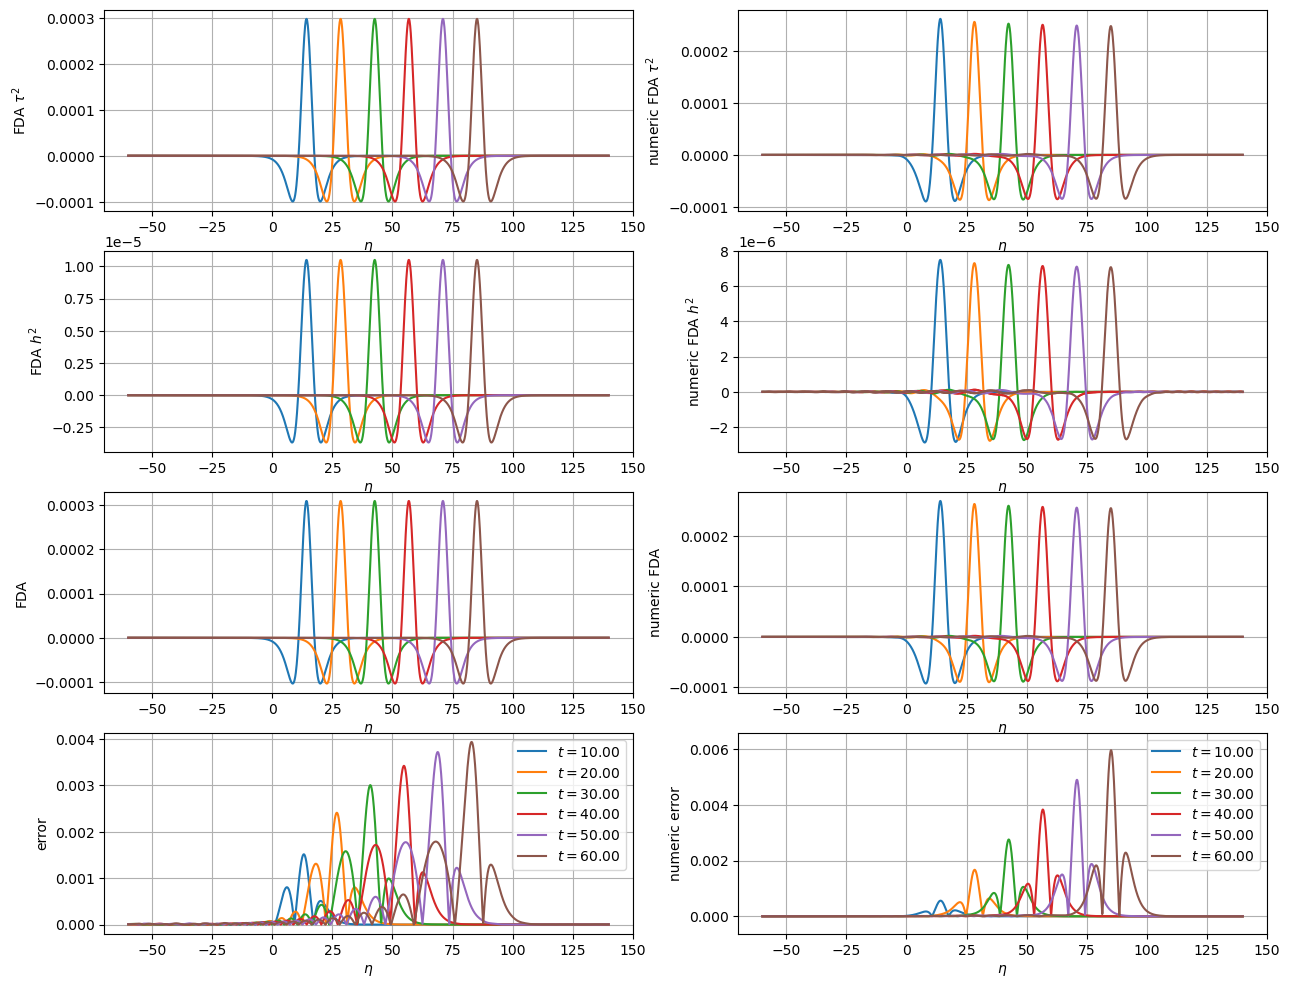

In [10]:
draw1(sol2, ex1m, ex1mFDAtau2, ex1mFDAh2, args, name="")
draw1(sol2, ex1m, ex1mFDAtau2, ex1mFDAh2, args, name="ex1mFDA.pdf")

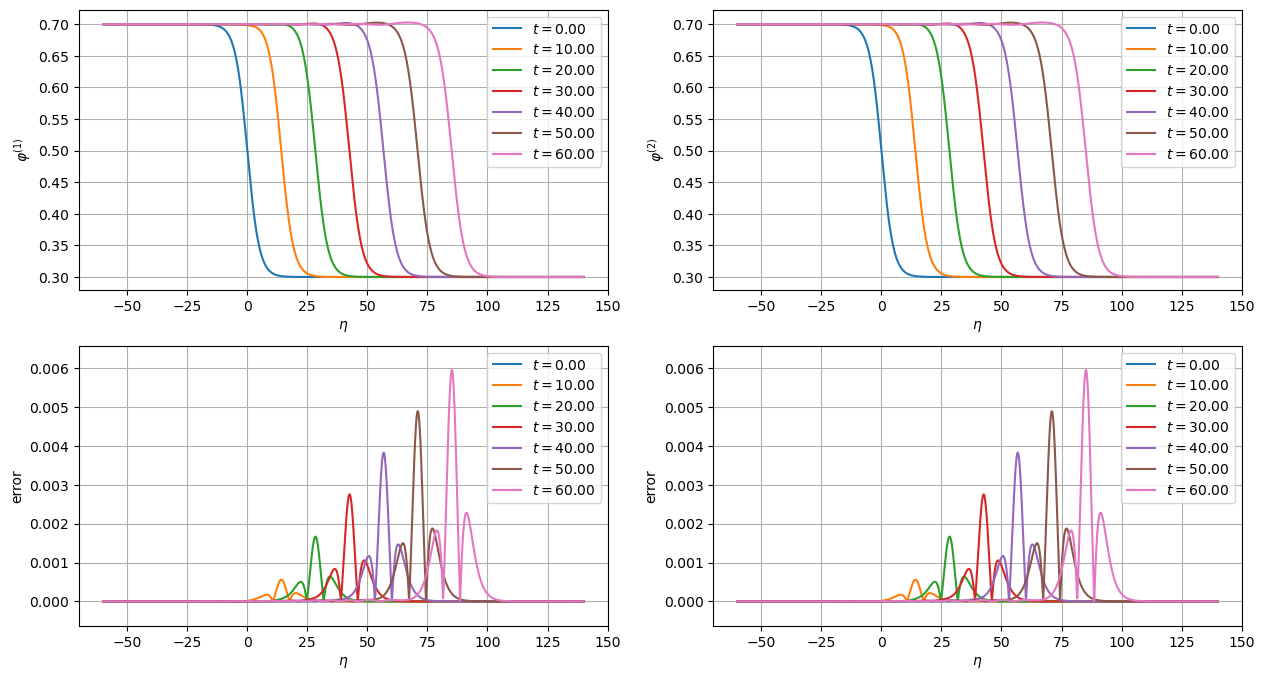

In [11]:
draw(sol1, sol2, name="")
draw(sol1, sol2, name="ex1m.pdf")

In [26]:
s0, s1 = 1., 1
f2, f3, sigma = 3.*s0, 2.*s1, 0.
x = array(linspace(-L*.3, L*.7, N), dtype=float64)
k, D = 0.2, 1.
args = [k, D]
dx = x[1] - x[0]
print(k**7/k**11)
dt = 0.1*dx
sol1, sol2 = solve(ex2(0., x, args), ex2(0., x, args), dt, dx, 7., 7)

624.9999999999999
dt=0.0125, t1=7.0, шагов=560, вывод через 80 шагов
3 3 3 3 3 3 

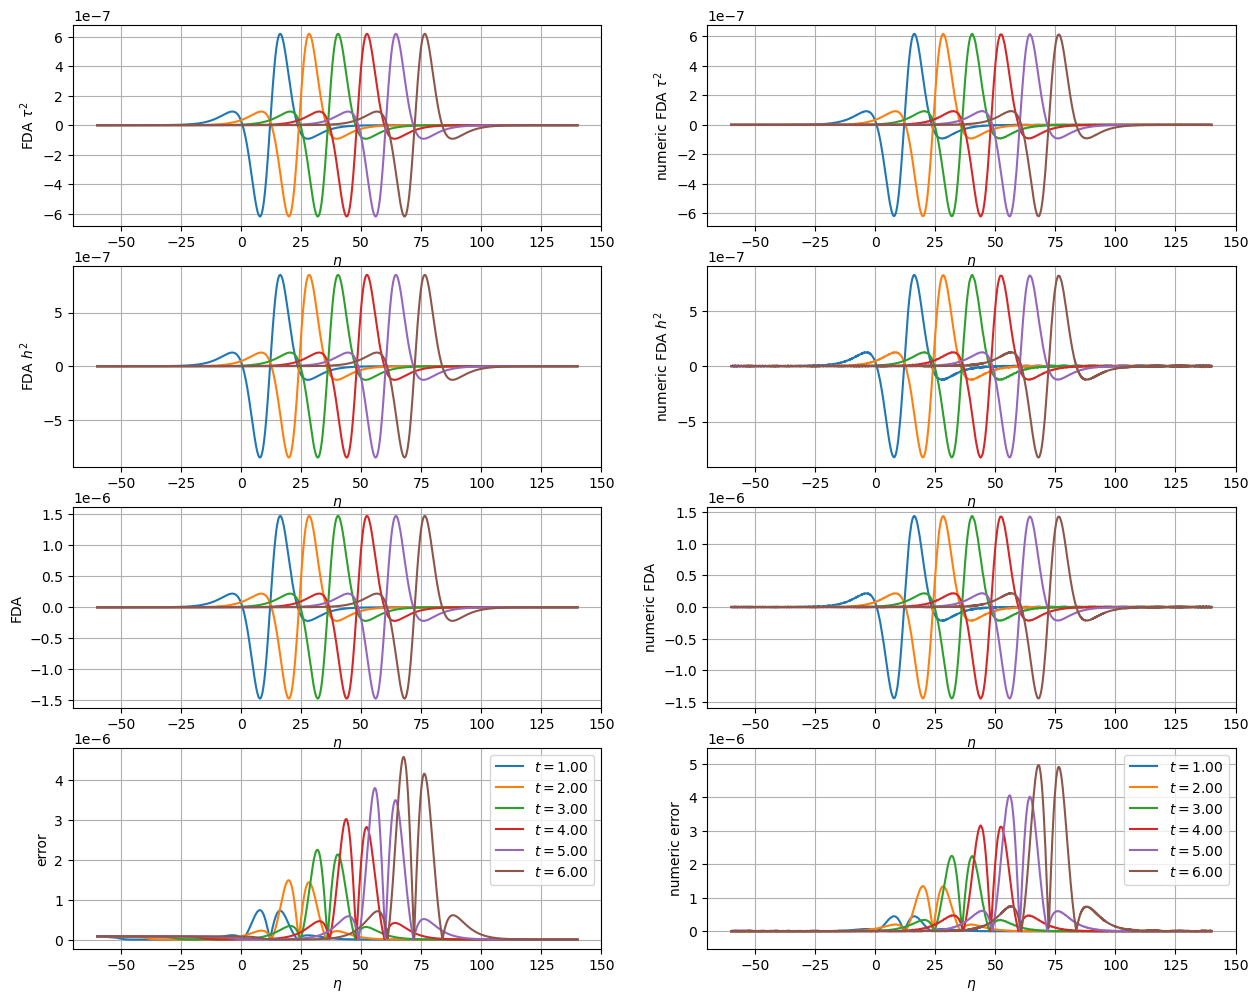

In [28]:
draw1(sol1, ex2, ex2FDAtau2, ex2FDAh2, args, name="")
draw1(sol1, ex2, ex2FDAtau2, ex2FDAh2, args, name="ex2FDAp.pdf")

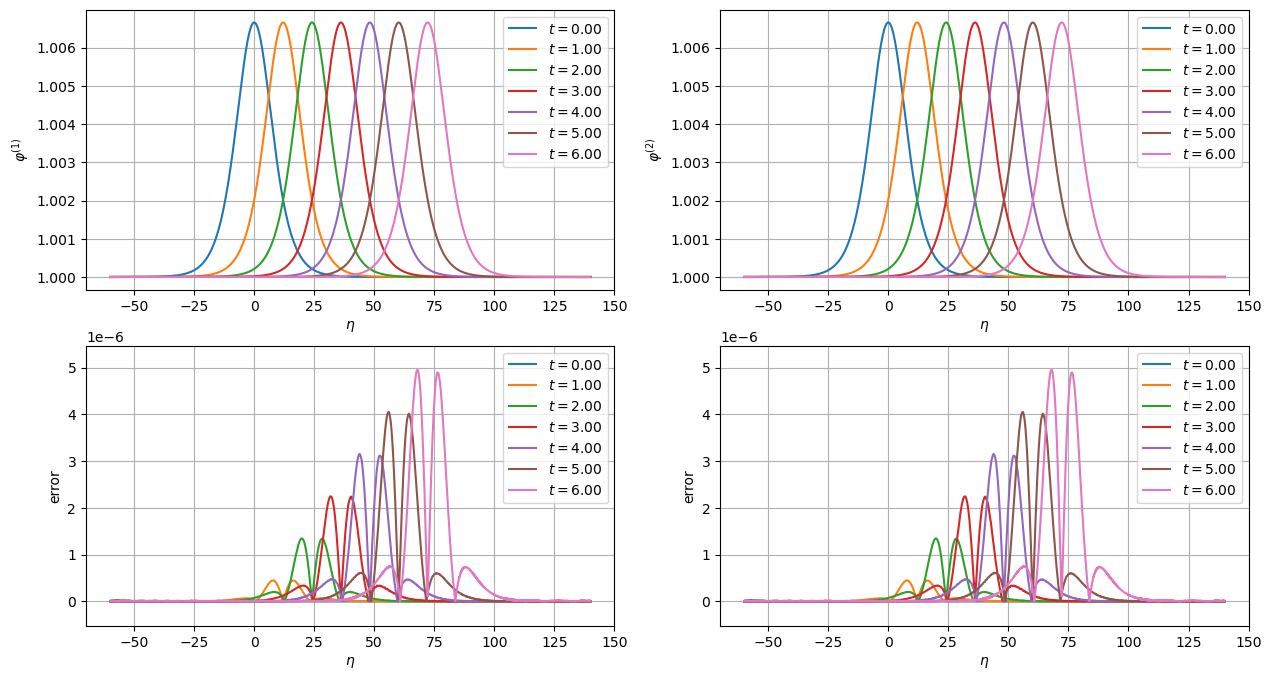

In [29]:
draw(sol1, sol2, name="")
draw(sol1, sol2, name="ex2p.pdf")

In [33]:
s0, s1 = 1., -1
f2, f3, sigma = 3.*s0, 2.*s1, 0.
x = array(linspace(-L*.7, L*.3, N), dtype=float64)
k, D = 0.2, -1.
args = [k, D]
dx = x[1] - x[0]
print(k**7/k**11)
dt = 0.1*dx
sol1, sol2 = solve(ex2(0., x, args), ex2(0., x, args), dt, dx, 7., 7)

624.9999999999999
dt=0.0125, t1=7.0, шагов=560, вывод через 80 шагов
3 3 3 3 3 3 

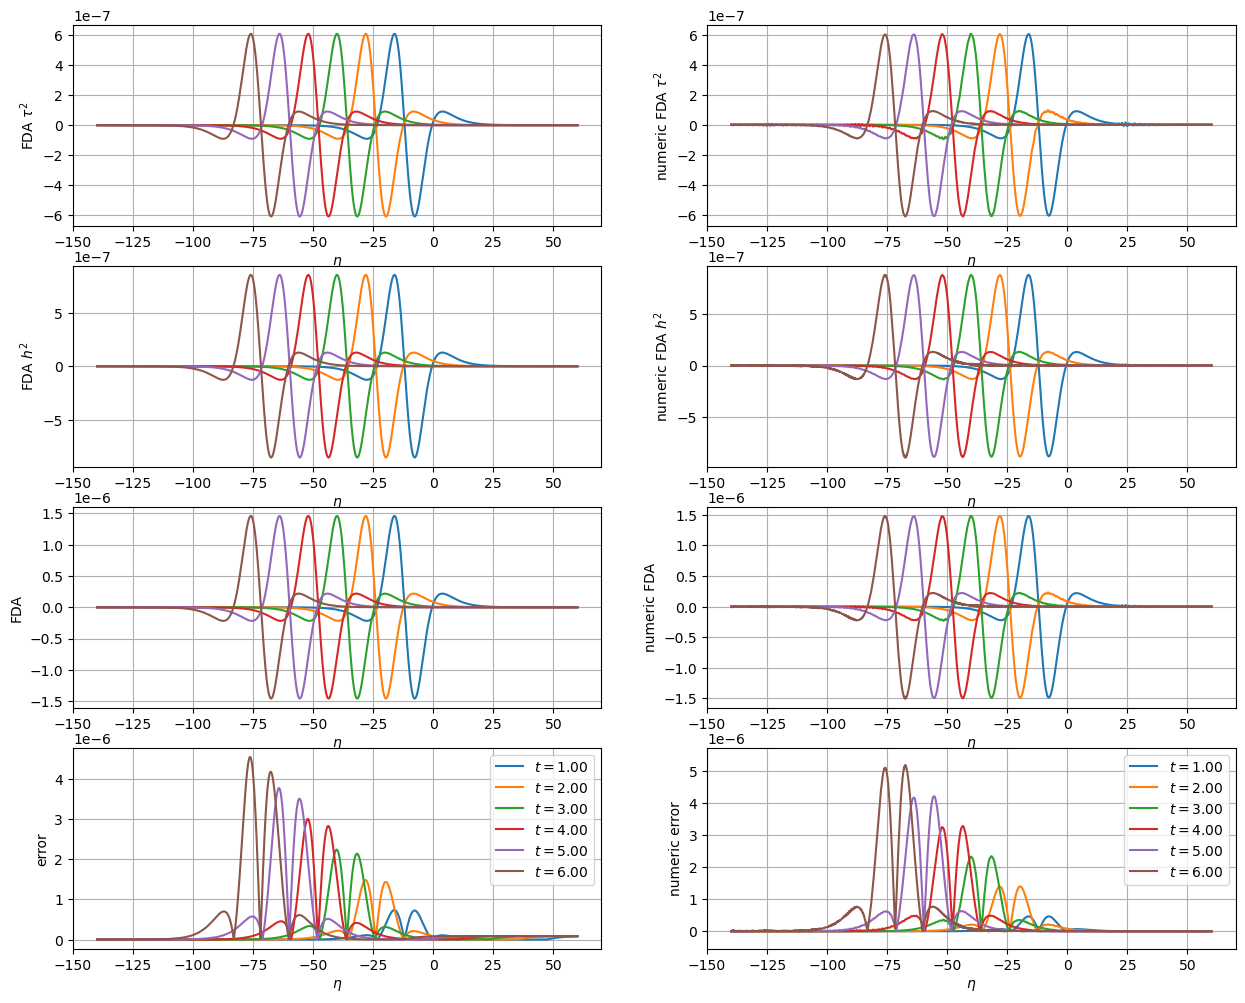

In [34]:
draw1(sol1, ex2, ex2FDAtau2, ex2FDAh2, args, name="")
draw1(sol1, ex2, ex2FDAtau2, ex2FDAh2, args, name="ex2FDAm.pdf")

In [15]:
s0, s1 = 1., 0.
f2, f3, sigma = 3.*s0, 2.*s1, 0.
x = array(linspace(-L*.2, L*.8, N), dtype=float64)
k = 0.2
args = [k]
dx = x[1] - x[0]
print(k**7/k**11)
dt = 5.*dx
sol1, sol2 = solve(ex3(0., x, args), ex3(0., x, args), dt, dx, 800., 7)

624.9999999999999
dt=0.625, t1=800.0, шагов=1280, вывод через 182 шагов
3 3 3 3 3 3 3 

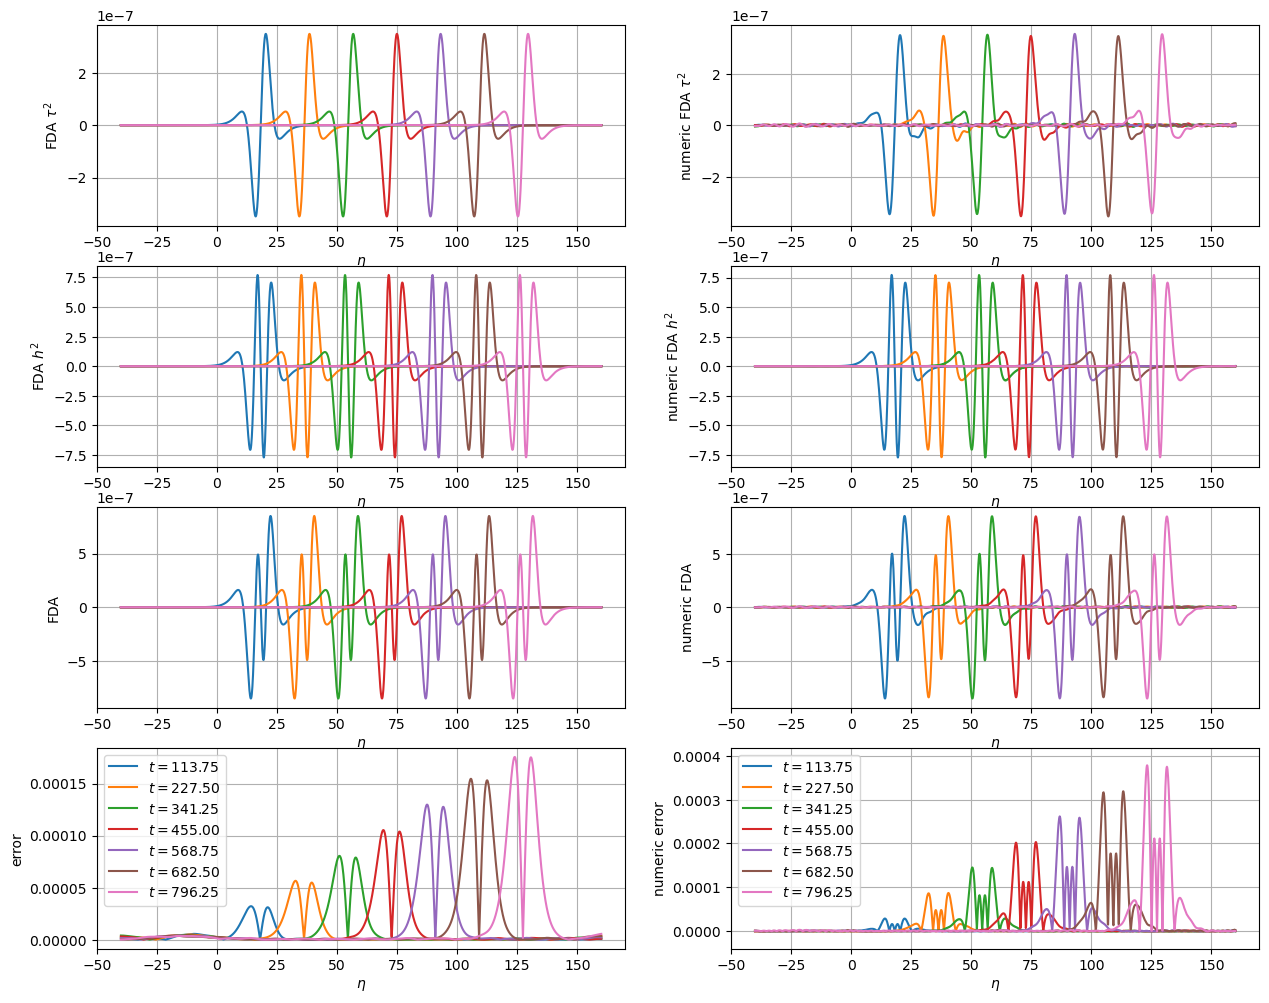

In [16]:
draw1(sol1, ex3, ex3FDAtau2, ex3FDAh2, args, name="")
draw1(sol1, ex3, ex3FDAtau2, ex3FDAh2, args, name="ex3FDA.pdf")

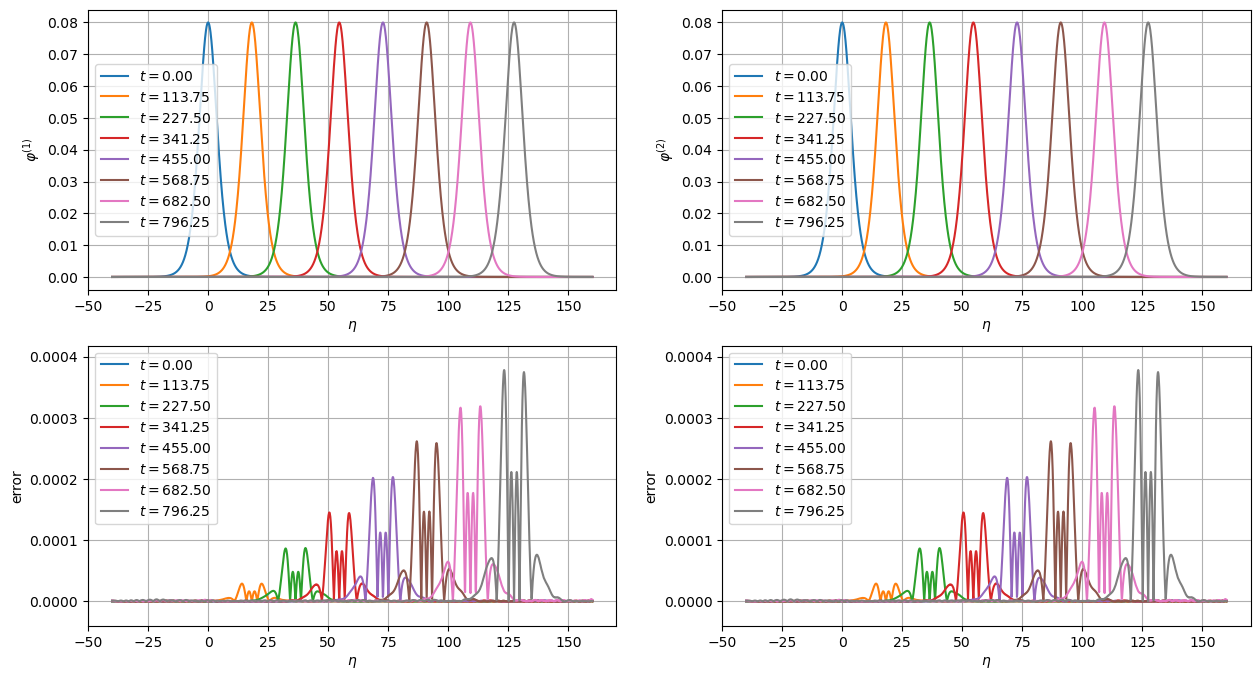

In [17]:
draw(sol1, sol2, name="")
draw(sol1, sol2, name="ex3.pdf")

In [24]:
s0, s1 = 1., 1.
f2, f3, sigma = 3.*s0, 2.*s1, 0.5
x = array(linspace(-L*.4, L*.6, N), dtype=float64)
k, D = 0.2, 0.2
args = [k, D]
dx = x[1] - x[0]
print(k**7/k**11)
dt = 0.1*dx
sol1, sol2 = solve(ex2(0., x, args), 0.*ex2(0., x, args), dt, dx, 5., 7)

624.9999999999999
dt=0.0125, t1=5.0, шагов=400, вывод через 57 шагов
3 3 3 3 3 3 

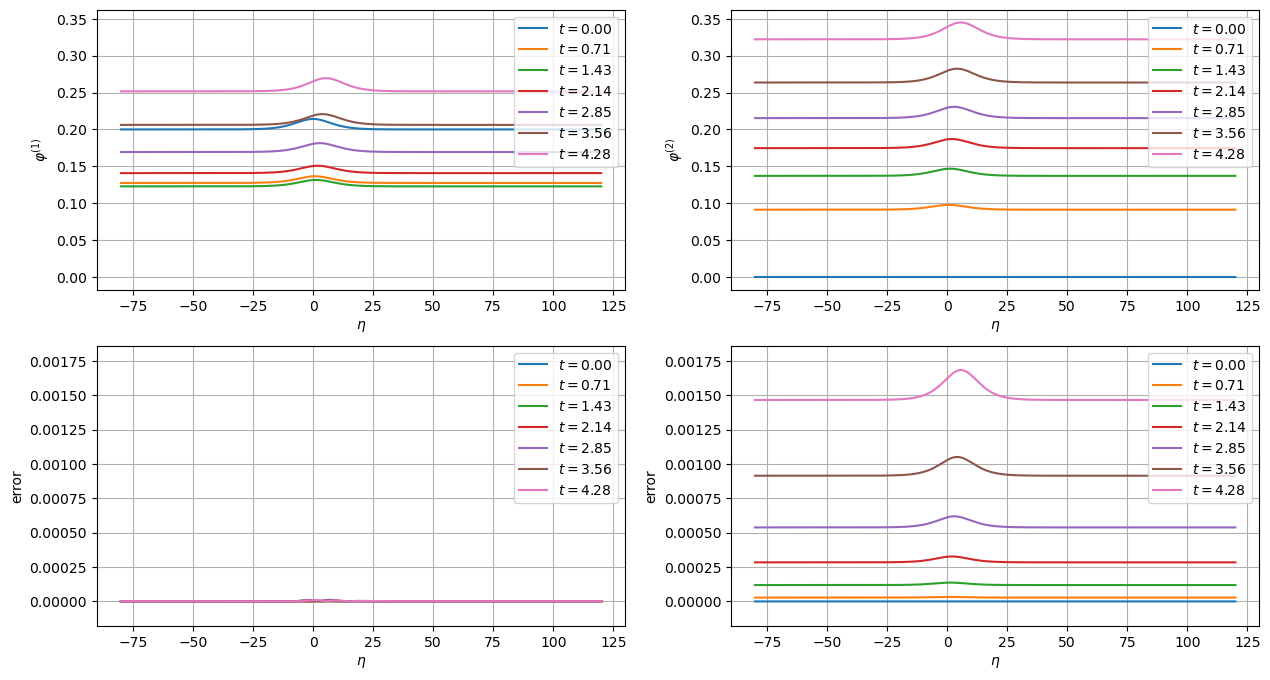

In [25]:
draw(sol1, sol2, name="")
draw(sol1, sol2, name="ex20sp.pdf")

In [26]:
s0, s1 = 1., 1.
f2, f3, sigma = 3.*s0, 2.*s1, -0.5
x = array(linspace(-L*.4, L*.6, N), dtype=float64)
k, D = 0.2, 0.2
args = [k, D]
dx = x[1] - x[0]
print(k**7/k**11)
dt = 0.1*dx
sol1, sol2 = solve(ex2(0., x, args), 0.*ex2(0., x, args), dt, dx, 5., 7)

624.9999999999999
dt=0.0125, t1=5.0, шагов=400, вывод через 57 шагов
3 3 3 3 3 3 

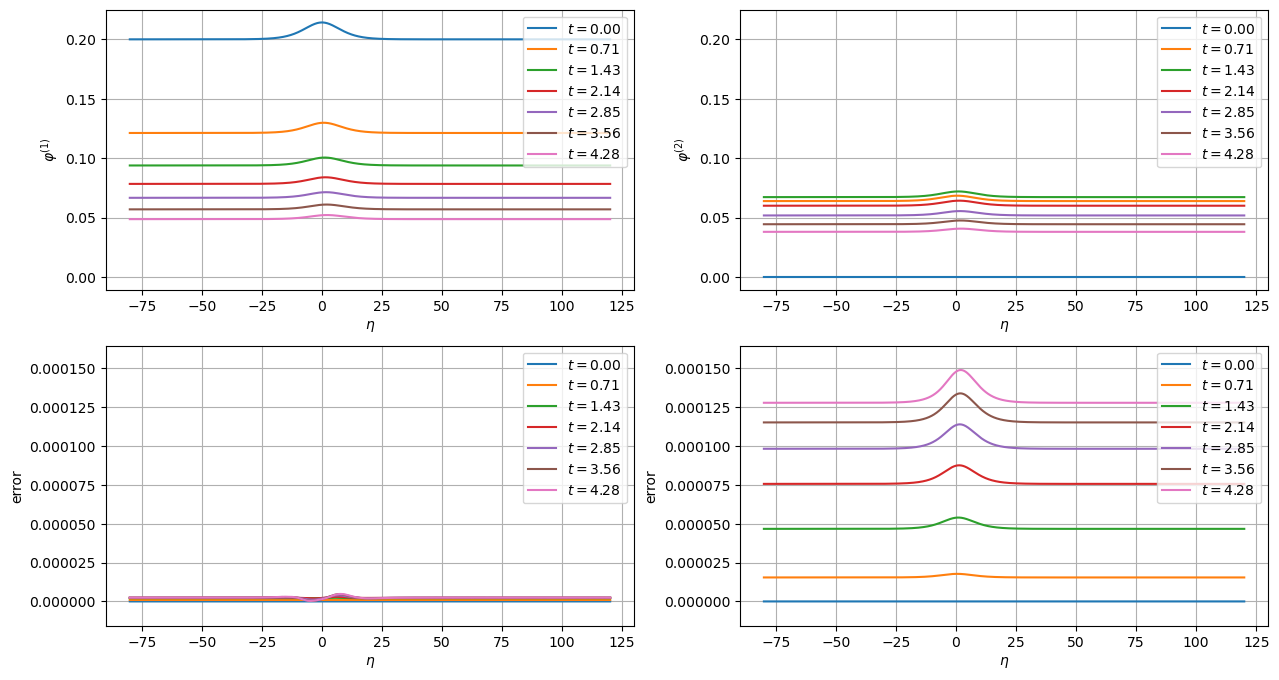

In [27]:
draw(sol1, sol2, name="")
draw(sol1, sol2, name="ex20sm.pdf")

In [37]:
s0, s1 = 1., 1.
f2, f3, sigma = 3.*s0, 2.*s1, 0.5
x = array(linspace(-L*.4, L*.6, N), dtype=float64)
k, D = 0.2, 0.2
args = [k, D]
dx = x[1] - x[0]
print(k**7/k**11)
dt = 0.1*dx
sol1, sol2 = solve(ex2(0., x, args), 0.*ex2(0., x, args), dt, dx, 7., 7)

624.9999999999999
dt=0.0125, t1=7.0, шагов=560, вывод через 80 шагов
3 3 3 3 3 3 

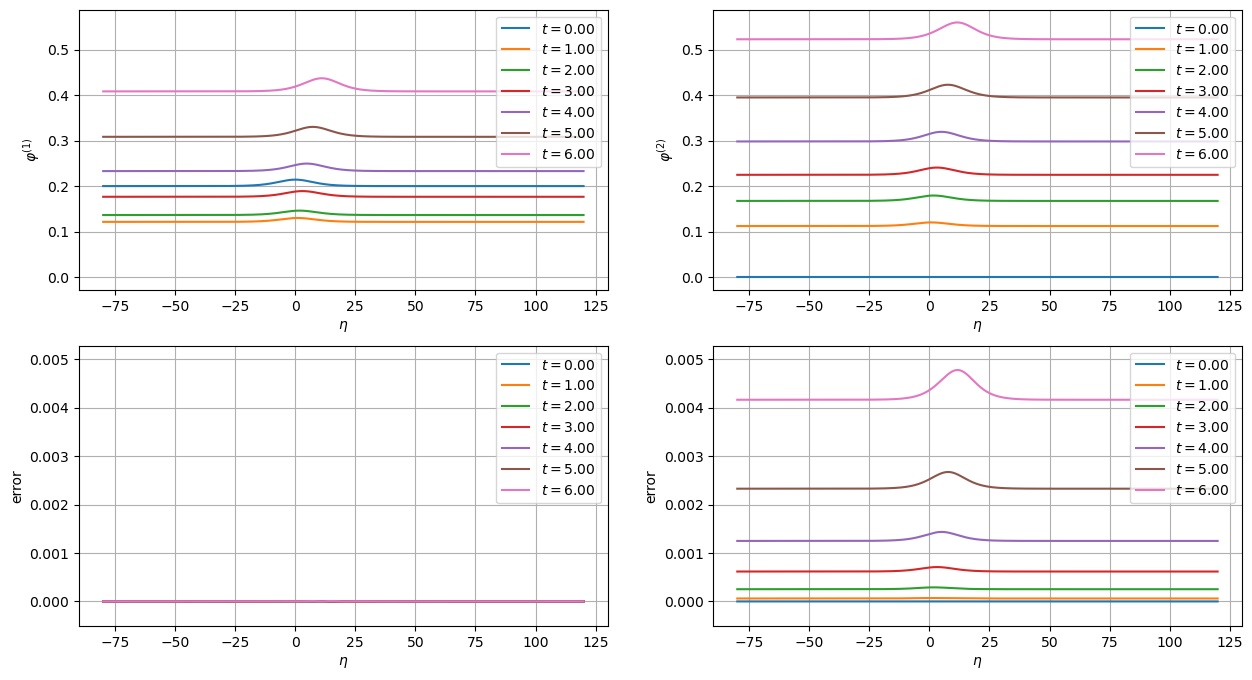

In [38]:
draw(sol1, sol2, name="")
draw(sol1, sol2, name="ex21pp.pdf")

In [30]:
s0, s1 = 1., 1.
f2, f3, sigma = 3.*s0, 2.*s1, -0.5
x = array(linspace(-L*.4, L*.6, N), dtype=float64)
k, D = 0.2, 0.2
args = [k, D]
dx = x[1] - x[0]
print(k**7/k**11)
dt = 0.1*dx
sol1, sol2 = solve(ex2(0., x, args), 0.*ex2(0., x, args), dt, dx, 7., 7)

624.9999999999999
dt=0.0125, t1=7.0, шагов=560, вывод через 80 шагов
3 3 3 3 3 3 

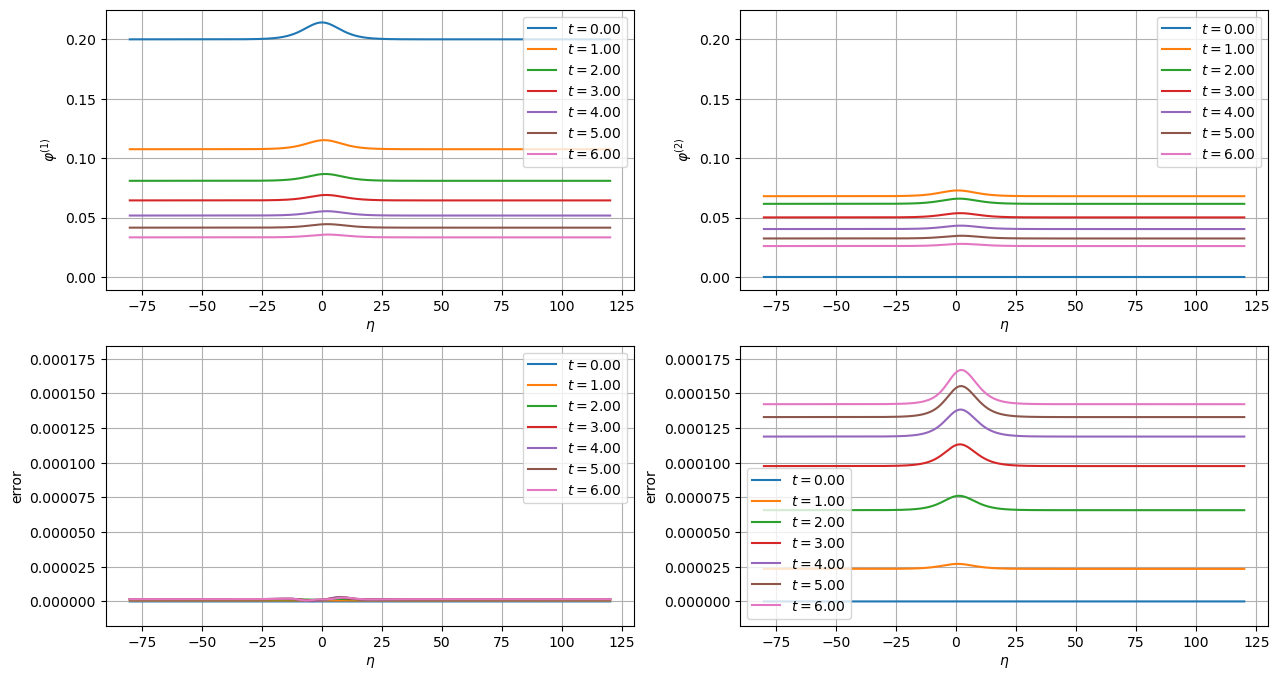

In [38]:
draw(sol1, sol2, name="")
draw(sol1, sol2, name="ex21pm.pdf")

In [39]:
s0, s1 = 1., -1.
f2, f3, sigma = 3.*s0, 2.*s1, 0.5
x = array(linspace(-L*.4, L*.6, N), dtype=float64)
k, D = 0.2, 0.2
args = [k, D]
dx = x[1] - x[0]
print(k**7/k**11)
dt = 0.1*dx
sol1, sol2 = solve(ex2(0., x, args), 0.*ex2(0., x, args), dt, dx, 7., 7)

624.9999999999999
dt=0.0125, t1=7.0, шагов=560, вывод через 80 шагов
3 3 3 3 3 3 

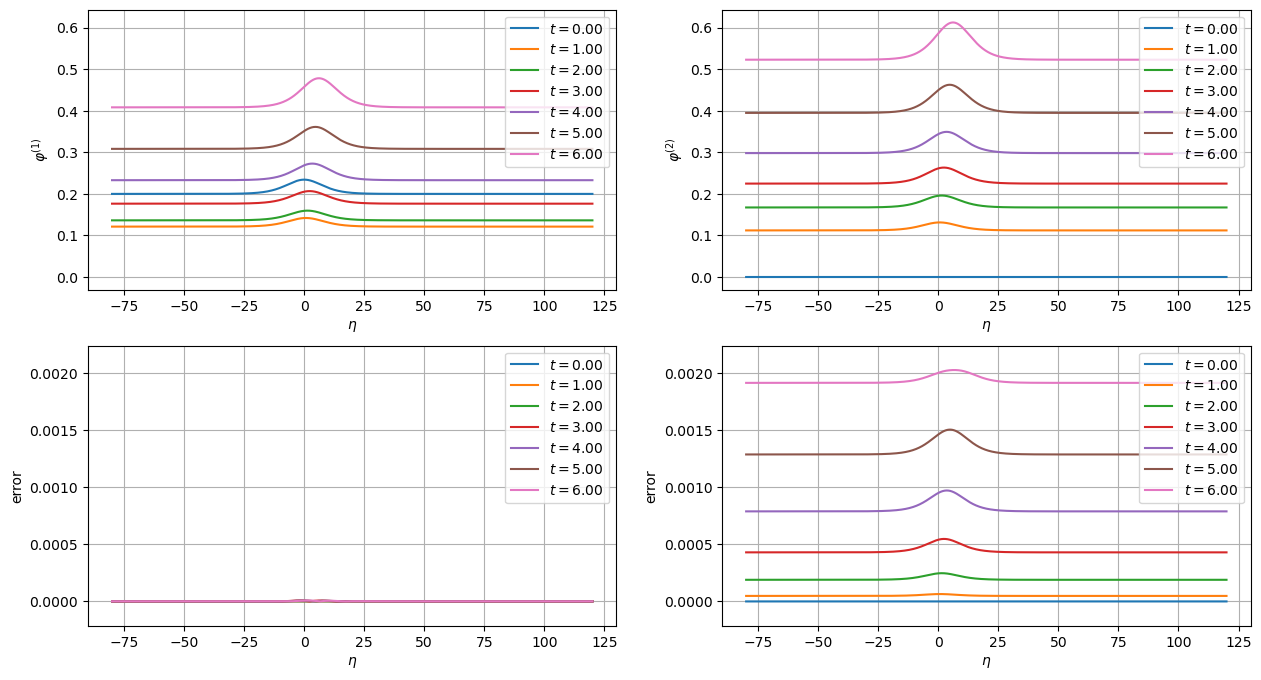

In [40]:
draw(sol1, sol2, name="")
draw(sol1, sol2, name="ex21mp.pdf")

In [41]:
s0, s1 = 1., -1.
f2, f3, sigma = 3.*s0, 2.*s1, -0.5
x = array(linspace(-L*.4, L*.6, N), dtype=float64)
k, D = 0.2, 0.2
args = [k, D]
dx = x[1] - x[0]
print(k**7/k**11)
dt = 0.1*dx
sol1, sol2 = solve(ex2(0., x, args), 0.*ex2(0., x, args), dt, dx, 7., 7)

624.9999999999999
dt=0.0125, t1=7.0, шагов=560, вывод через 80 шагов
3 3 3 3 3 3 

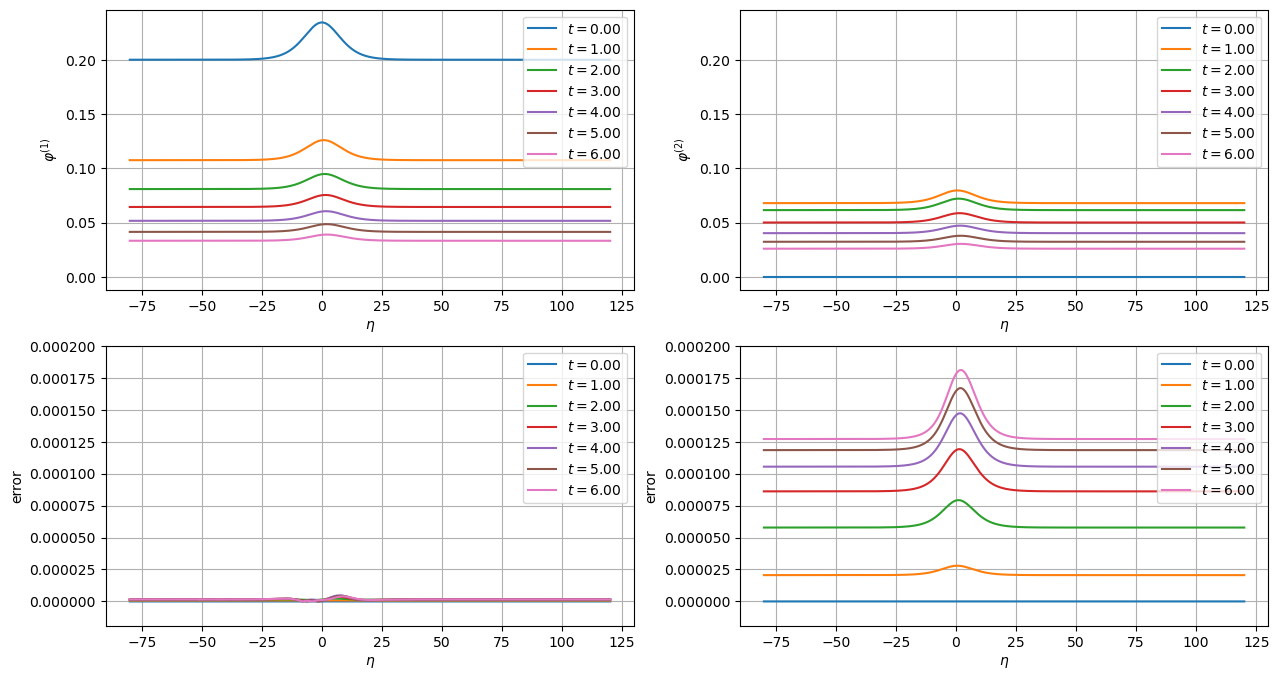

In [42]:
draw(sol1, sol2, name="")
draw(sol1, sol2, name="ex21mm.pdf")

In [22]:
s0, s1 = 1., 0.
f2, f3, sigma = 3.*s0, 2.*s1, 0.7
x = array(linspace(-L*.2, L*.8, N), dtype=float64)
k = 0.2
args = [k]
dx = x[1] - x[0]
print(k**7/k**11)
dt = .5*dx
sol1, sol2 = solve(ex3(0., x, args), 0.*ex3(0., x, args), dt, dx, 4., 7)

624.9999999999999
dt=0.0625, t1=4.0, шагов=64, вывод через 9 шагов
3 3 3 3 3 3 

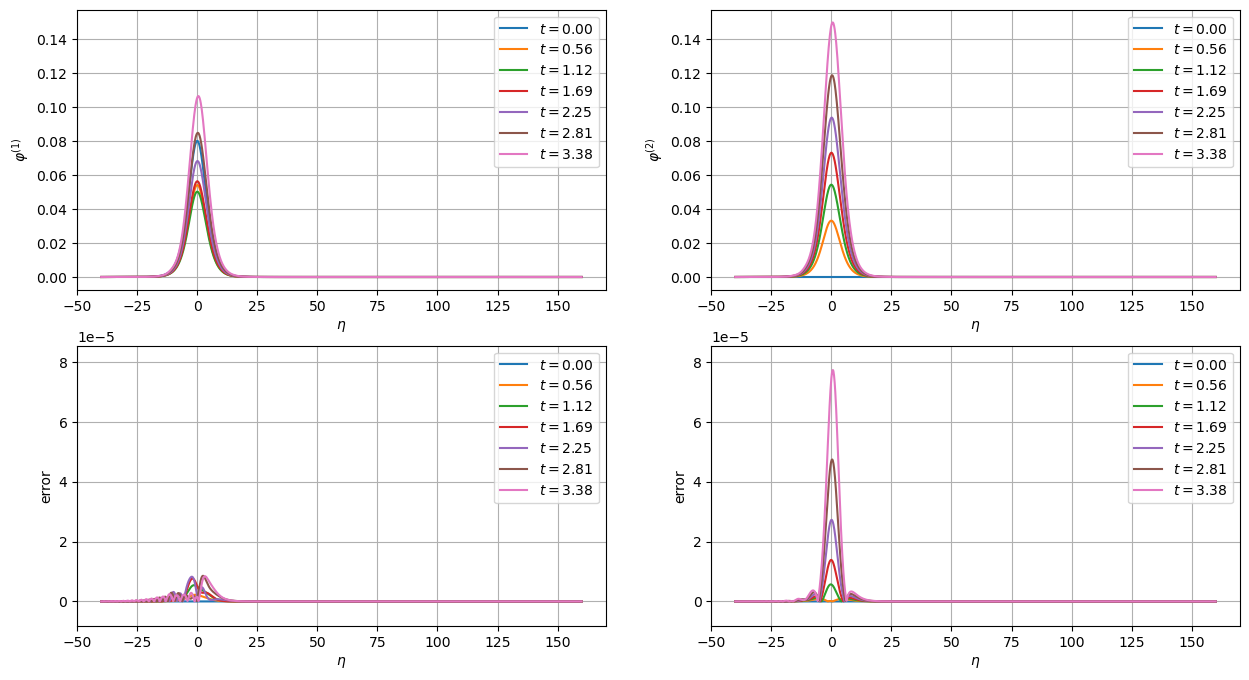

In [23]:
draw(sol1, sol2, name="")
draw(sol1, sol2, name="ex30sp.pdf")

In [39]:
s0, s1 = 1., -1.
f2, f3, sigma = 3.*s0, 2.*s1, 0.5
x = array(linspace(-L*.7, L*.7, N), dtype=float64)
k = 0.2
args = [k]
dx = x[1] - x[0]
print(k**7/k**11)
dt = .1*dx
sol1, sol2 = solve(ex1p(0., x, args), 0.*ex1p(0., x, args), dt, dx, 3., 7)

624.9999999999999
dt=0.017500000000001136, t1=3.0, шагов=171, вывод через 24 шагов
3 3 3 3 3 3 3 

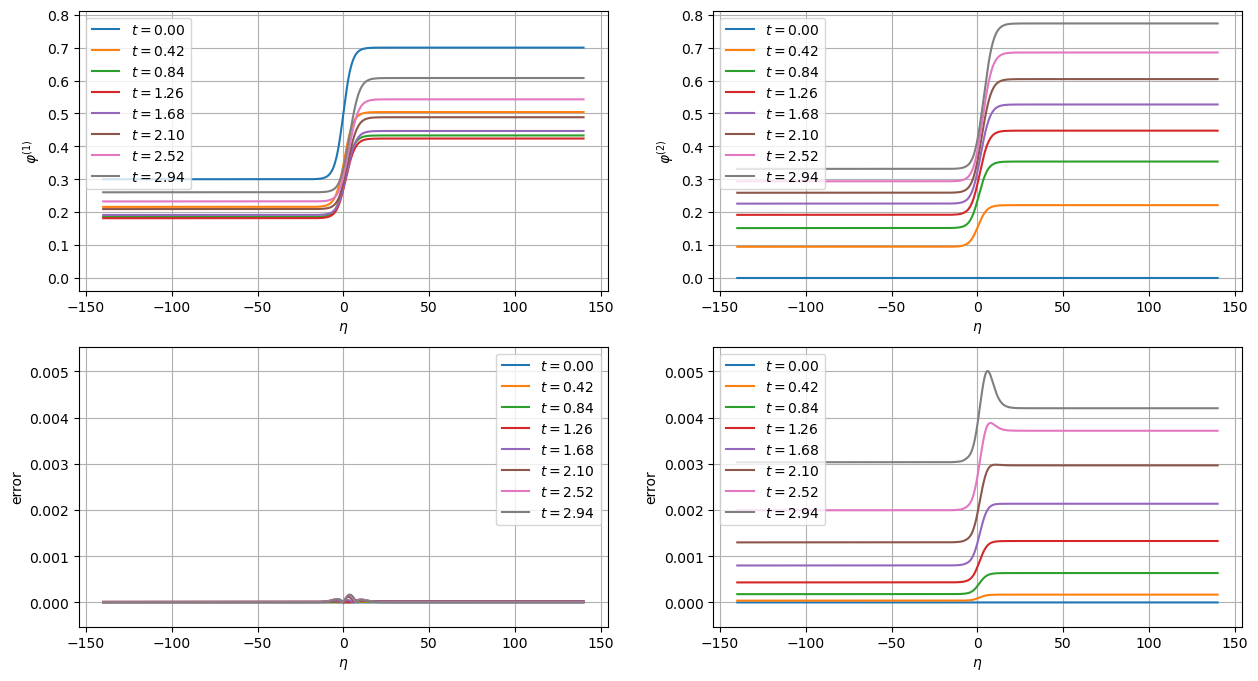

In [40]:
draw(sol1, sol2, name="")
draw(sol1, sol2, name="ex1p0sp.pdf")

In [41]:
s0, s1 = 1., -1.
f2, f3, sigma = 3.*s0, 2.*s1, 0.5
x = array(linspace(-L*.7, L*.7, N), dtype=float64)
k = 0.2
args = [k]
dx = x[1] - x[0]
print(k**7/k**11)
dt = .1*dx
sol1, sol2 = solve(ex1m(0., x, args), 0.*ex1m(0., x, args), dt, dx, 3., 7)

624.9999999999999
dt=0.017500000000001136, t1=3.0, шагов=171, вывод через 24 шагов
3 3 3 3 3 3 3 

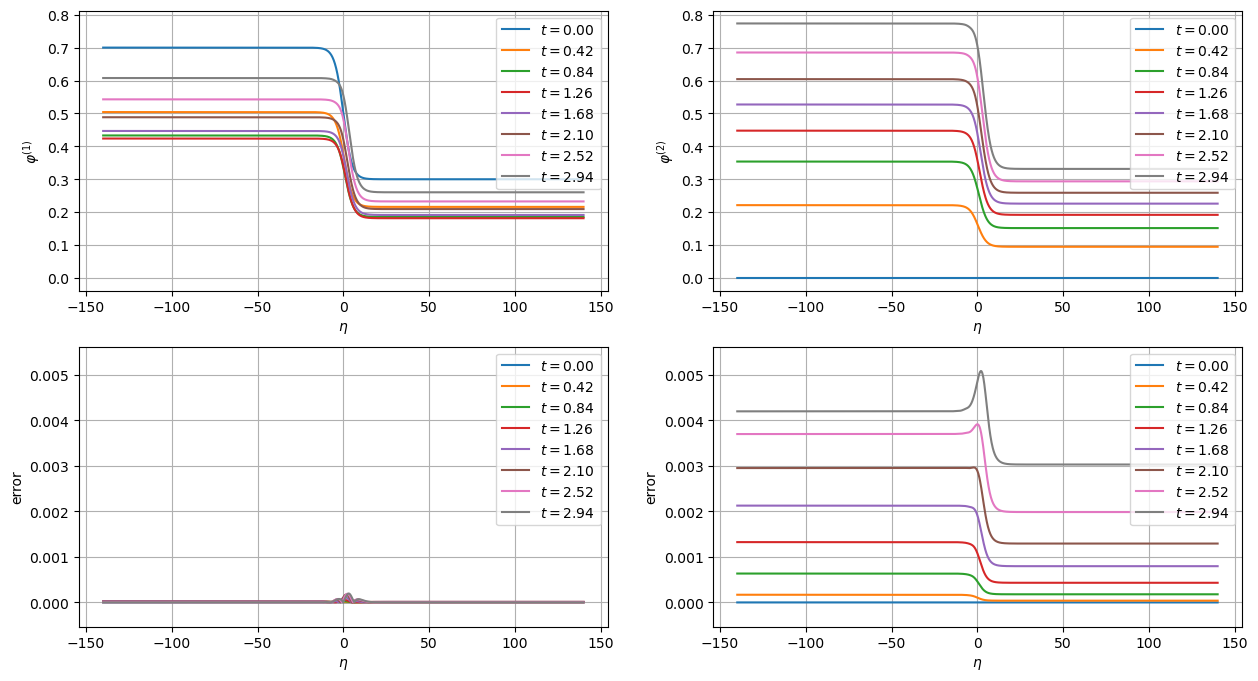

In [42]:
draw(sol1, sol2, name="")
draw(sol1, sol2, name="ex1m0sp.pdf")

In [43]:
s0, s1 = 1., -1.
f2, f3, sigma = 3.*s0, 2.*s1, -0.5
x = array(linspace(-L*.7, L*.7, N), dtype=float64)
k = 0.2
args = [k]
dx = x[1] - x[0]
print(k**7/k**11)
dt = .1*dx
sol1, sol2 = solve(ex1m(0., x, args), 0.*ex1m(0., x, args), dt, dx, 3., 7)

624.9999999999999
dt=0.017500000000001136, t1=3.0, шагов=171, вывод через 24 шагов
3 3 3 3 3 3 3 

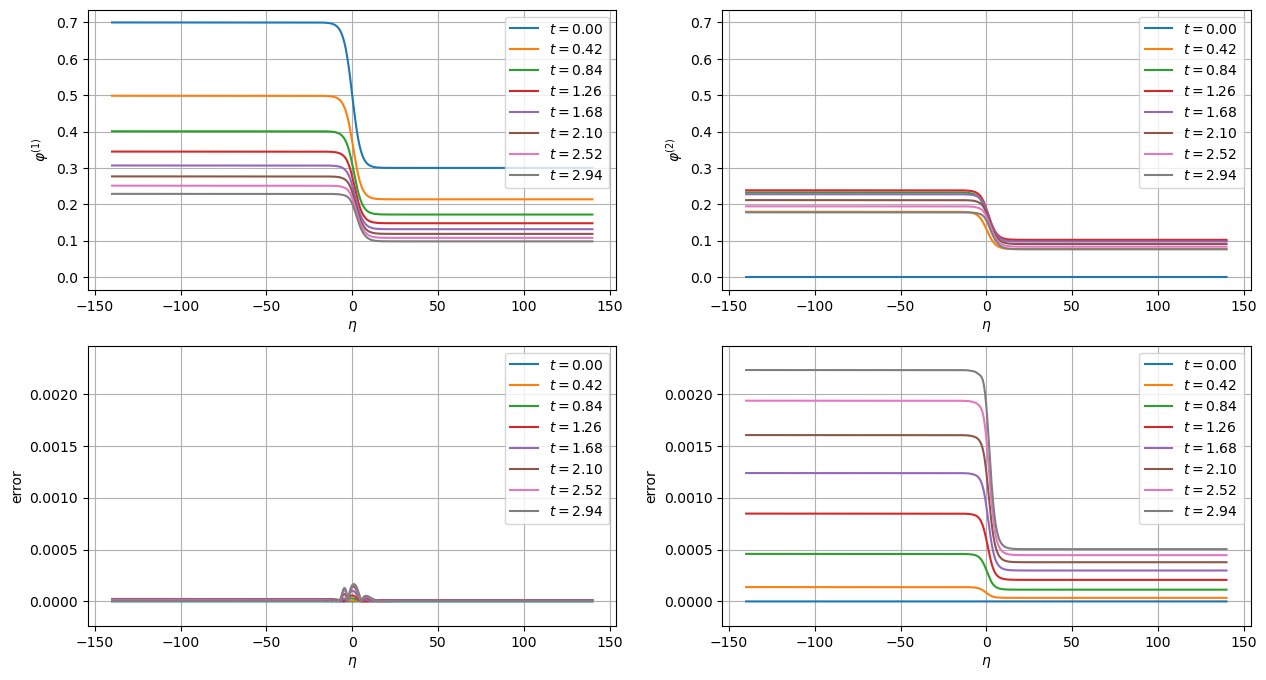

In [44]:
draw(sol1, sol2, name="")
draw(sol1, sol2, name="ex1m0sm.pdf")

In [28]:
s0, s1 = 1., -1.
f2, f3, sigma = 3.*s0, 2.*s1, 0.7
x = array(linspace(-L*.5, L*.5, N), dtype=float64)
k = 0.2
args = [k]
dx = x[1] - x[0]
print(k**7/k**11)
dt = .1*dx
sol1, sol2 = solve(ex1p(0., x, args), 0.*ex1p(0., x, args), dt, dx, 5., 7)

624.9999999999999
dt=0.0125, t1=5.0, шагов=400, вывод через 57 шагов
3 3 3 3 3 3 

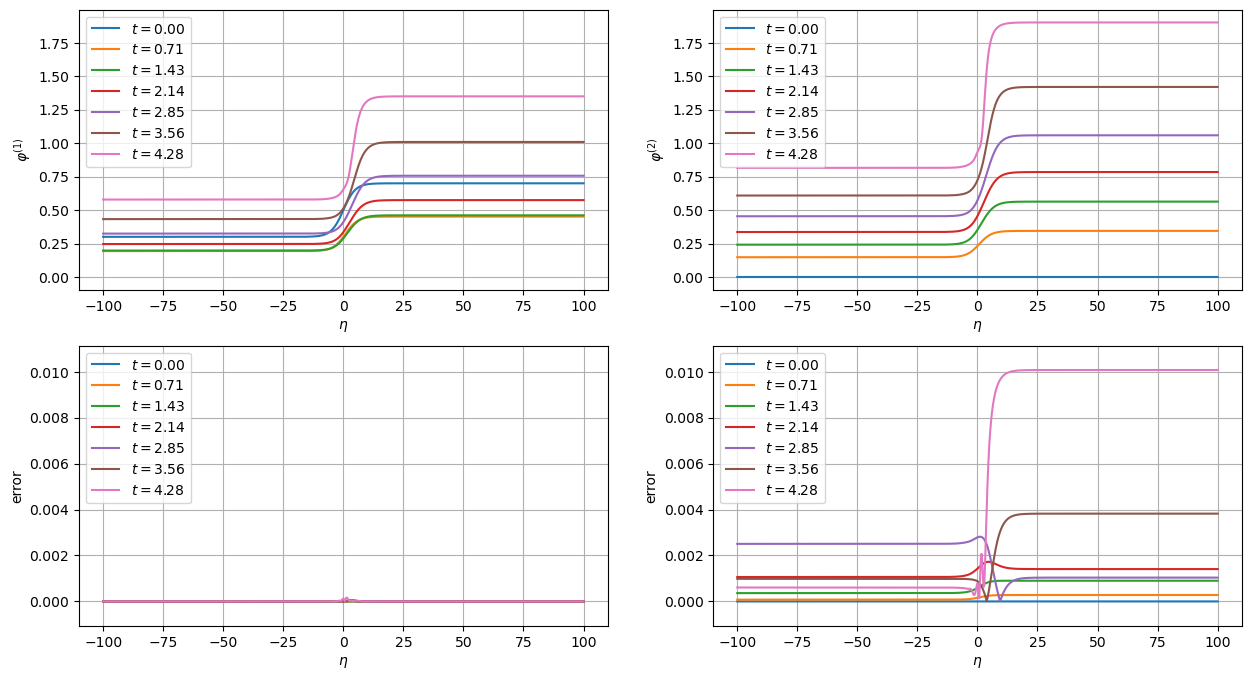

In [29]:
draw(sol1, sol2, loc="upper left", name="")
draw(sol1, sol2, loc="upper left", name="ex1p1sp.pdf")

In [30]:
s0, s1 = 1., -1.
f2, f3, sigma = 3.*s0, 2.*s1, 0.7
x = array(linspace(-L*.5, L*.5, N), dtype=float64)
k = 0.2
args = [k]
dx = x[1] - x[0]
print(k**7/k**11)
dt = .1*dx
sol1, sol2 = solve(ex1m(0., x, args), 0.*ex1m(0., x, args), dt, dx, 5., 7)

624.9999999999999
dt=0.0125, t1=5.0, шагов=400, вывод через 57 шагов
3 3 3 3 3 3 

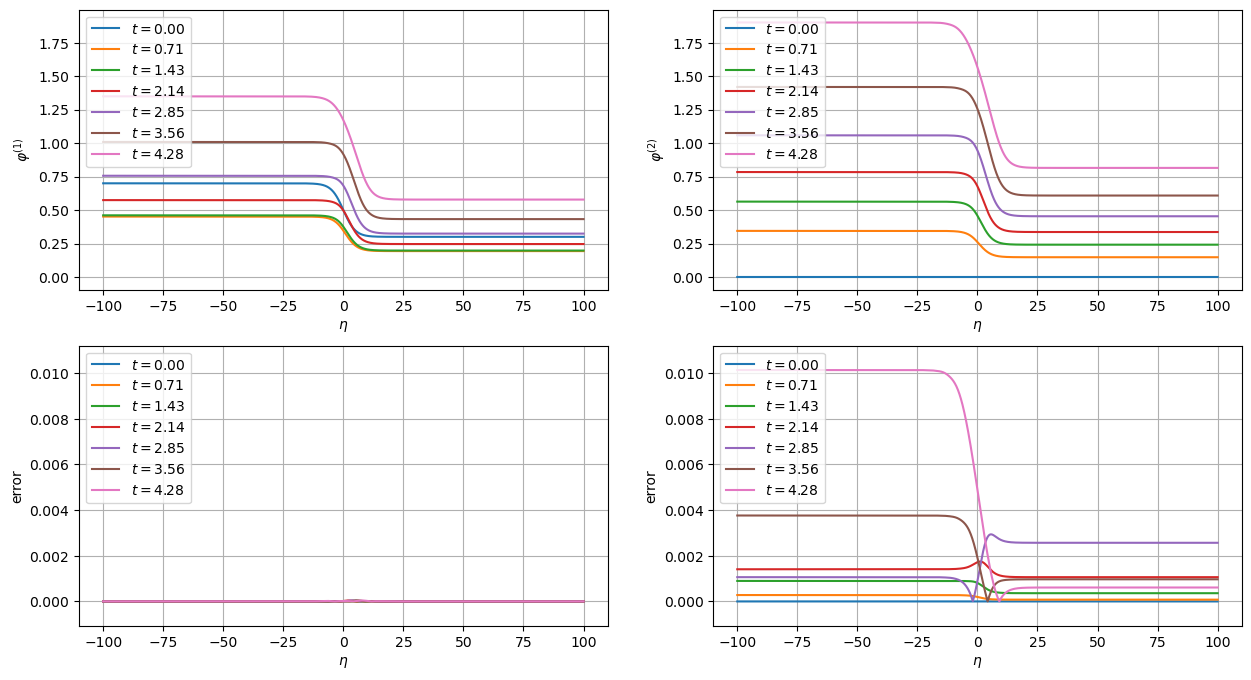

In [31]:
draw(sol1, sol2, loc="upper left", name="")
draw(sol1, sol2, loc="upper left", name="ex1m1sp.pdf")

In [32]:
s0, s1 = 0., -1.
f2, f3, sigma = 3.*s0, 2.*s1, 0.7
x = array(linspace(-L*.5, L*.5, N), dtype=float64)
k = 0.2
args = [k]
dx = x[1] - x[0]
print(k**7/k**11)
dt = .1*dx
sol1, sol2 = solve(ex1p(0., x, args), 0.*ex1p(0., x, args), dt, dx, 5., 7)

624.9999999999999
dt=0.0125, t1=5.0, шагов=400, вывод через 57 шагов
3 3 3 3 3 3 

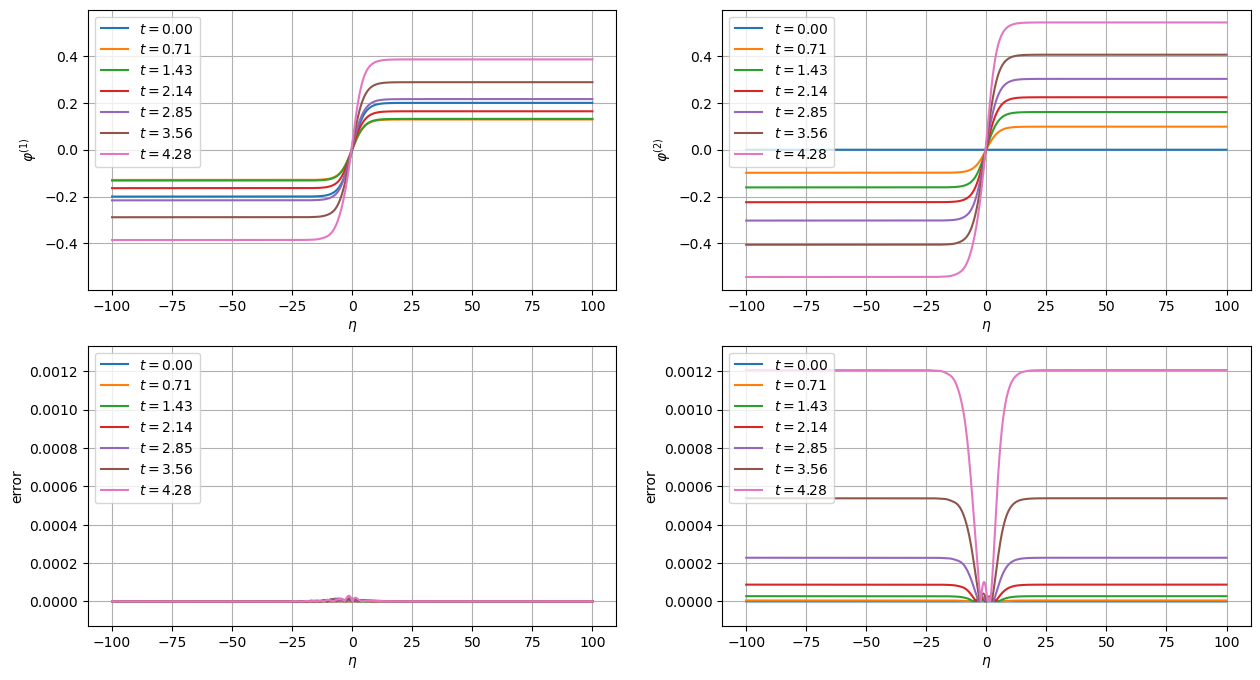

In [33]:
draw(sol1, sol2, loc="upper left", name="")
draw(sol1, sol2, loc="upper left", name="ex1p01sp.pdf")

In [34]:
s0, s1 = 0., -1.
f2, f3, sigma = 3.*s0, 2.*s1, 0.7
x = array(linspace(-L*.5, L*.5, N), dtype=float64)
k = 0.2
args = [k]
dx = x[1] - x[0]
print(k**7/k**11)
dt = .1*dx
sol1, sol2 = solve(ex1m(0., x, args), 0.*ex1m(0., x, args), dt, dx, 5., 7)

624.9999999999999
dt=0.0125, t1=5.0, шагов=400, вывод через 57 шагов
3 3 3 3 3 3 

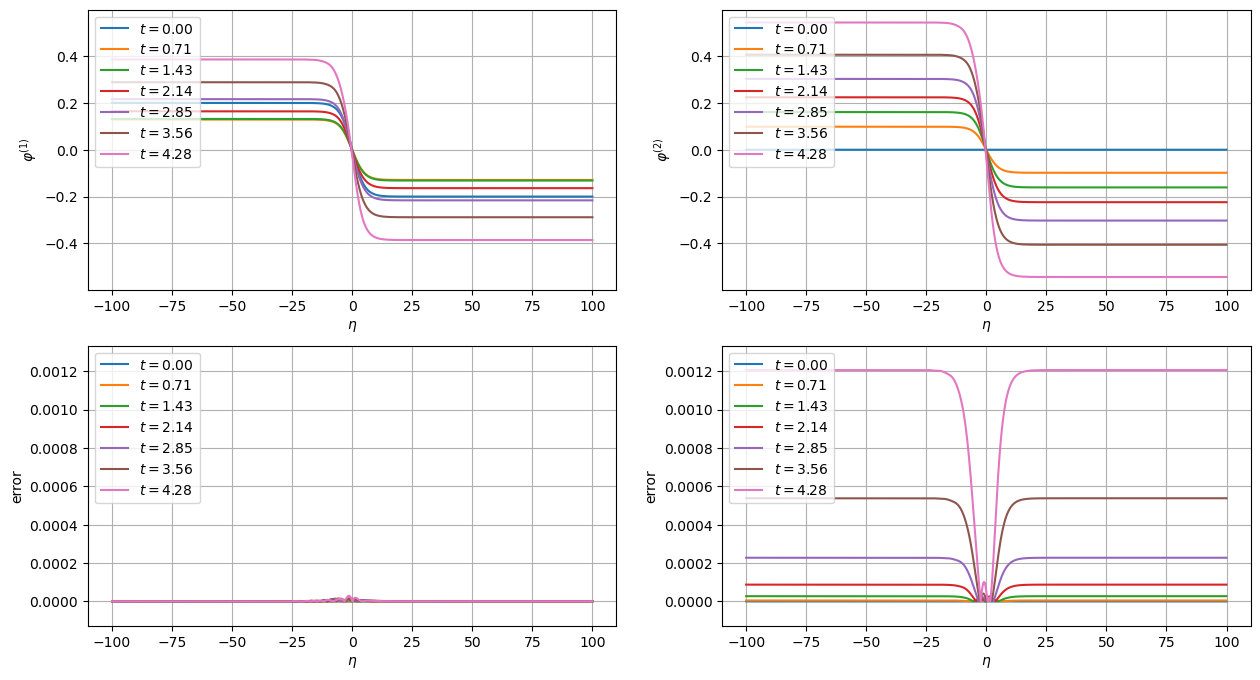

In [35]:
draw(sol1, sol2, loc="upper left", name="")
draw(sol1, sol2, loc="upper left", name="ex1m01sp.pdf")

In [36]:
s0, s1 = 1., 0.
f2, f3, sigma = 3.*s0, 2.*s1, -0.7
x = array(linspace(-L*.4, L*.6, N), dtype=float64)
k, D = 0.2, 0.2
args = [k, D]
dx = x[1] - x[0]
print(k**7/k**11)
dt = 0.1*dx
sol1, sol2 = solve(ex2(0., x, args), 0.*ex2(0., x, args), dt, dx, 7., 7)

624.9999999999999
dt=0.0125, t1=7.0, шагов=560, вывод через 80 шагов
3 3 3 3 3 3 

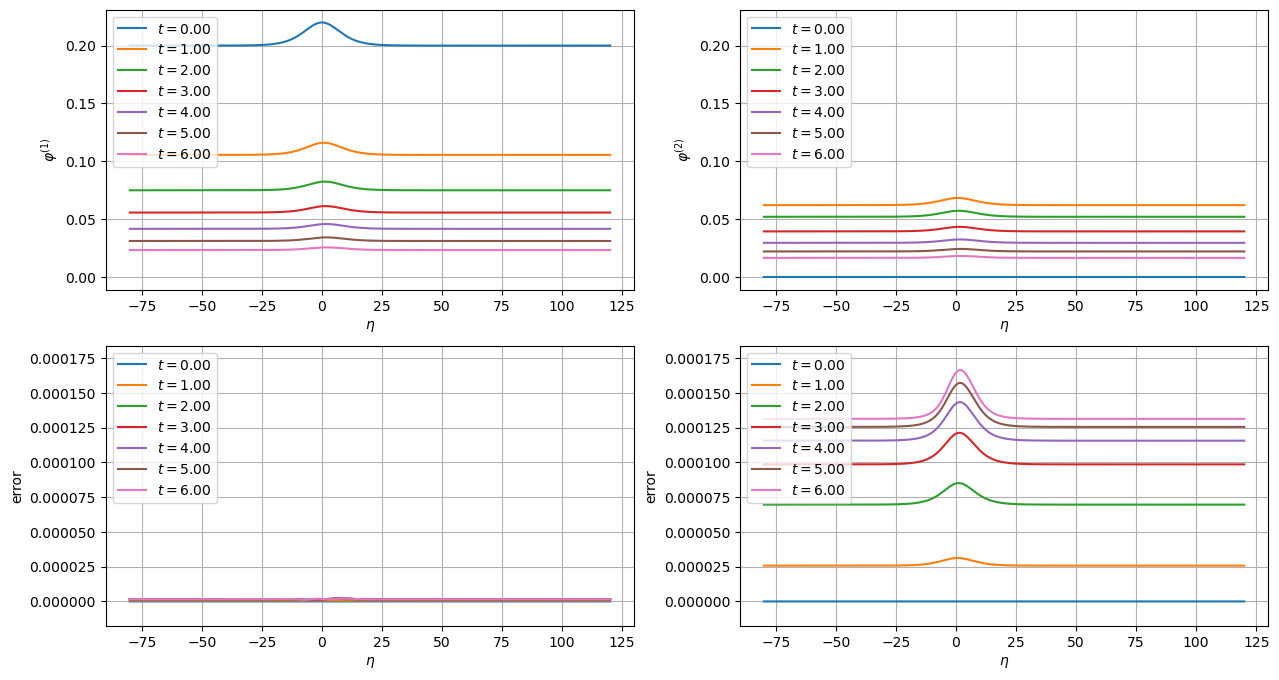

In [37]:
draw(sol1, sol2, loc="upper left", name="")
draw(sol1, sol2, loc="upper left", name="ex210sm.pdf")

In [38]:
s0, s1 = 0., -1.
f2, f3, sigma = 3.*s0, 2.*s1, -1.
x = array(linspace(-L*.8, L*.2, N), dtype=float64)
k = 0.2
args = [k]
dx = x[1] - x[0]
print(k**7/k**11)
dt = 0.5*dx
sol1, sol2 = solve(ex1m(0., x, args), ex1m(0., x, args), dt, dx, 3., 5)

624.9999999999999
dt=0.0625, t1=3.0, шагов=48, вывод через 9 шагов
3 3 3 3 3 

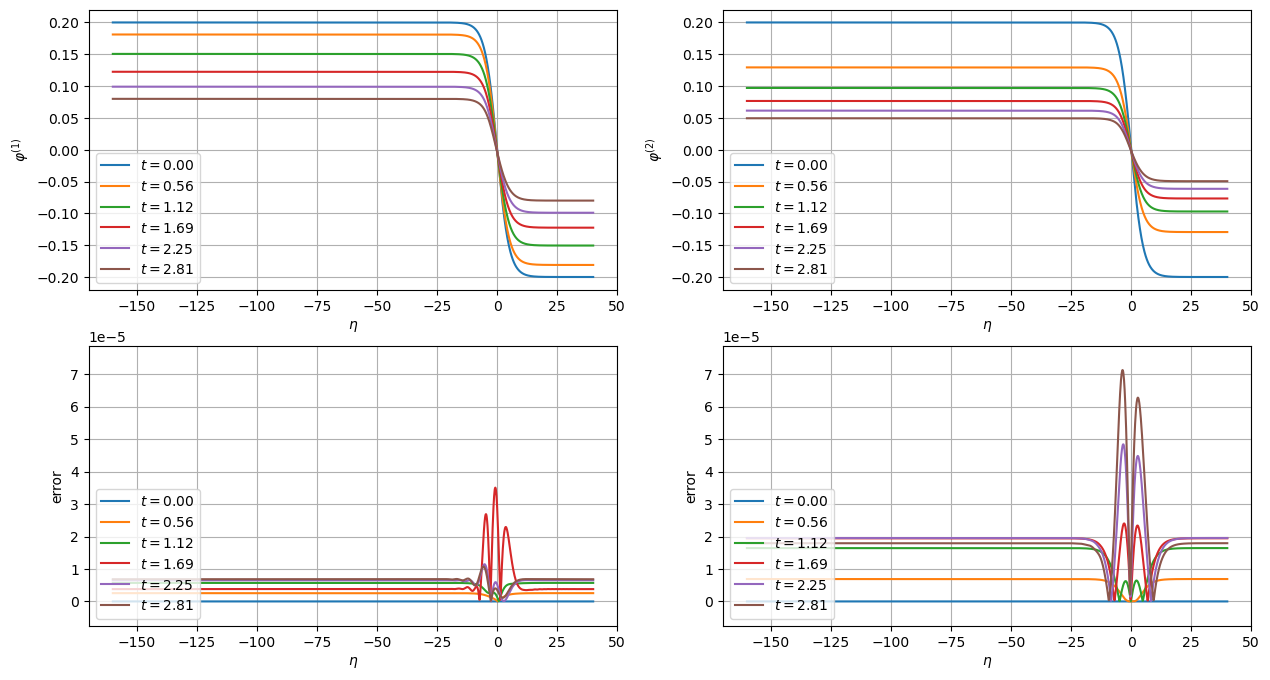

In [39]:
draw(sol1, sol2, loc='lower left', name="")

In [40]:
s0, s1 = 1., -1.
f2, f3, sigma = 3.*s0, 2.*s1, -1.
x = array(linspace(-L*.8, L*.2, N), dtype=float64)
k = 0.2
args = [k]
dx = x[1] - x[0]
print(k**7/k**11)
dt = 0.5*dx
sol1, sol2 = solve(ex1m(0., x, args), ex1m(0., x, args), dt, dx, 3., 5)

624.9999999999999
dt=0.0625, t1=3.0, шагов=48, вывод через 9 шагов
3 3 3 3 3 

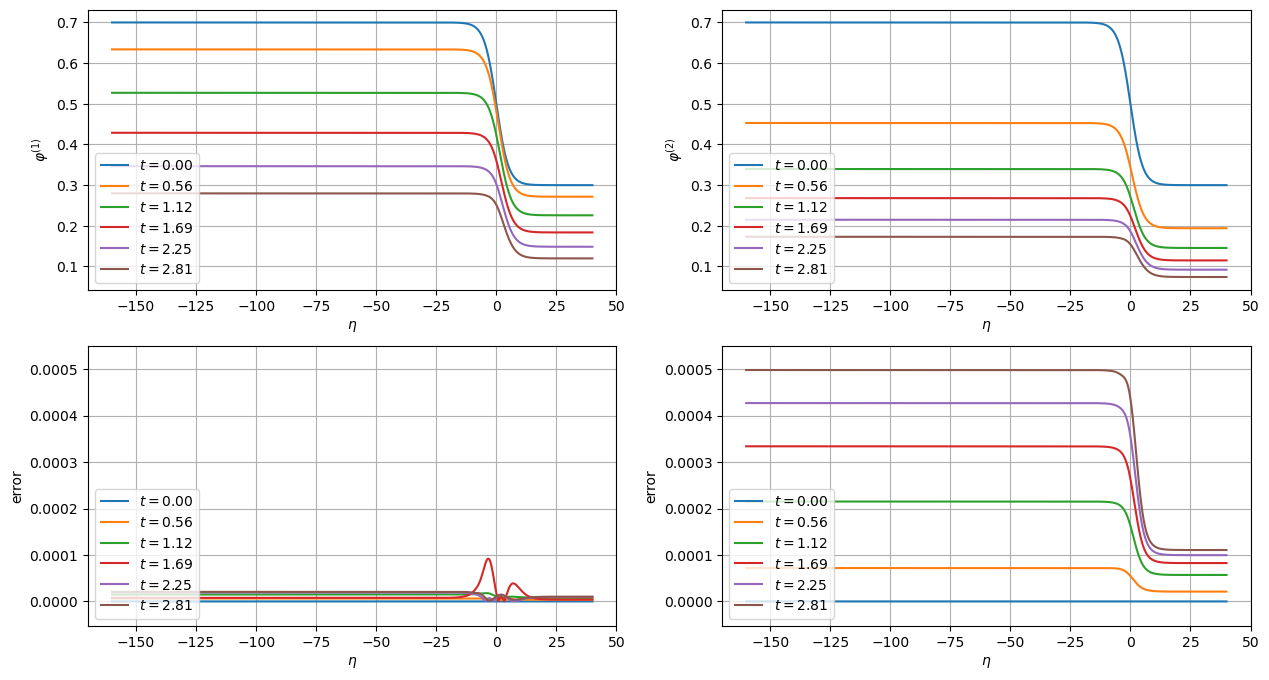

In [41]:
draw(sol1, sol2, loc='lower left', name="")

In [42]:
s0, s1 = 1., 0.
f2, f3, sigma = 3.*s0, 2.*s1, 1.
x = array(linspace(-L*.2, L*.8, N), dtype=float64)
k = 0.2
args = [k]
dx = x[1] - x[0]
print(k**7/k**11)
dt = .1*dx
sol1, sol2 = solve(ex3(0., x, args), ex3(0., x, args), dt, dx, 3., 7)

624.9999999999999
dt=0.0125, t1=3.0, шагов=240, вывод через 34 шагов
3 3 3 3 3 3 

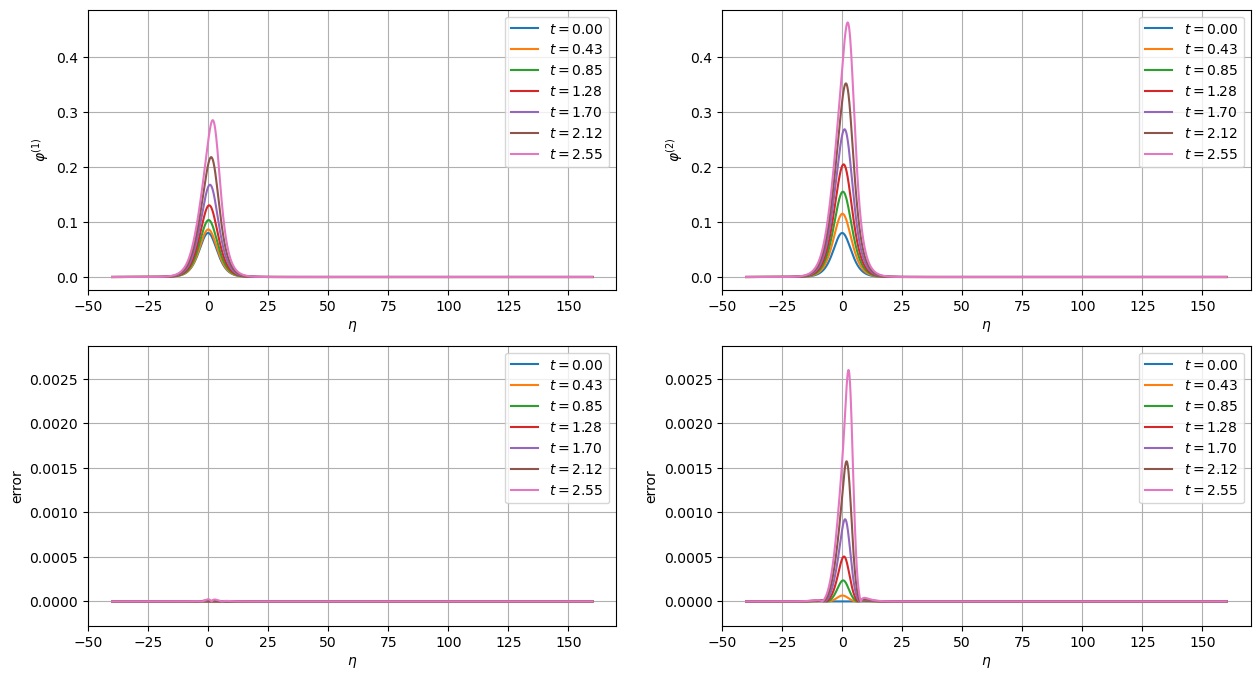

In [43]:
draw(sol1, sol2, loc='upper right', name="")

In [44]:
s0, s1 = 1., 0.
f2, f3, sigma = 3.*s0, 2.*s1, -1.
x = array(linspace(-L*.2, L*.8, N), dtype=float64)
k = 0.2
args = [k]
dx = x[1] - x[0]
print(k**7/k**11)
dt = .1*dx
sol1, sol2 = solve(ex3(0., x, args), ex3(0., x, args), dt, dx, 3., 7)

624.9999999999999
dt=0.0125, t1=3.0, шагов=240, вывод через 34 шагов
3 3 3 3 3 3 

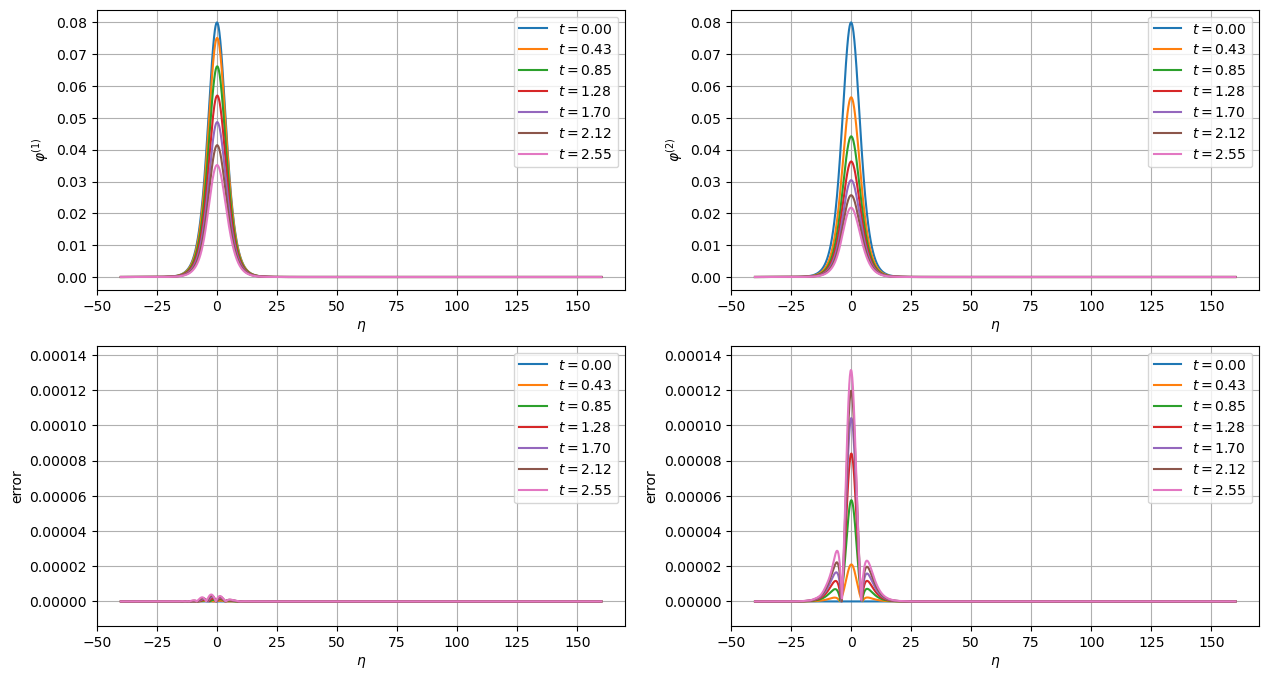

In [45]:
draw(sol1, sol2, loc='upper right', name="")